In [125]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from prophet import Prophet

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics


## Lectura y limpieza de datos
- lectura del .csv
- vista de los tipos de datos en DF original
- Creacion del df_todos que es identico al original, pero solo con las 4 columnas importantes

DF hasta noviembre (entrenamiento)
DF del mes de noviembre (testeo)
- Luego se crean otros 2 DF partiendo de las 2 anteriores:
  -  con las sumatorias de las ventas por dia



In [126]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [127]:
pd.set_option('display.float_format', '{:.4f}'.format)


In [128]:
# si se importa desde Drive
file_path = '/content/drive/MyDrive/DIPLOMADO/Proy_Final/datos/tabla_13_modif_top10ventas_nov.csv'
# si se importa subiendo el archivo
# file_name = "tabla_11_modif_top10ventas_nov.csv"
df = pd.read_csv(file_path)
df.head()

,CodigoSucursal,CodigoDepartamento,CodigoEstado,TipoMovimiento,DescripcionMovimiento,NumeroMovimiento,NumeroCorrelativo,FechaMovimiento,NombreProducto,UnidadMedida,CantidadSalida,PesoSalida,MontoBase,PrecioUnitario,CostoUnitario,MontoReferencia,NombreGrupo
0,13,1,AC,SVE,VENTA COMPUTARIZADA,18112062,0,2018-11-16 07:02:58,PIERNA MUSLO OFERTA,KG,0.0000,1.0433,14.6280,12.8800,12.8800,2.1013,TROZADO
1,13,1,AC,SVE,VENTA COMPUTARIZADA,18112055,0,2018-11-15 12:53:48,FILETE A GRANEL,KG,0.0000,1.9826,47.0120,21.8040,21.8040,6.7546,TROZADO
2,13,1,AC,SVE,VENTA COMPUTARIZADA,18112052,0,2018-11-15 12:12:18,FILETE A GRANEL,KG,0.0000,1.9246,45.6320,21.8040,21.8040,6.5559,TROZADO
3,13,1,AC,SVE,VENTA COMPUTARIZADA,18112050,0,2018-11-15 12:09:52,FILETE A GRANEL,KG,0.0000,0.8418,19.9640,21.8040,21.8040,2.8686,TROZADO
4,13,1,AC,SVE,VENTA COMPUTARIZADA,18112049,0,2018-11-15 12:05:05,PIERNA,KG,0.0000,0.1334,2.1160,14.7200,14.7200,0.3036,TROZADO


In [129]:
df['FechaMovimiento'] = pd.to_datetime(df['FechaMovimiento'])
df['year'] = df['FechaMovimiento'].dt.year
df.dtypes

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CodigoSucursal                    int64
CodigoDepartamento                int64
CodigoEstado                     object
TipoMovimiento                   object
DescripcionMovimiento            object
NumeroMovimiento                  int64
NumeroCorrelativo                 int64
FechaMovimiento          datetime64[ns]
NombreProducto                   object
UnidadMedida                     object
CantidadSalida                  float64
PesoSalida                      float64
MontoBase                       float64
PrecioUnitario                  float64
CostoUnitario                   float64
MontoReferencia                 float64
NombreGrupo                      object
year                              int64
dtype: object

In [130]:
df_todo = df[['NombreProducto',
              'FechaMovimiento',
              'MontoBase',
              'year'
              ]]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [131]:
#df_todo = df_todo.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})
df_todo.sort_values(by='FechaMovimiento', inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-131-3f20b1242116>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_todo.sort_values(by='FechaMovimiento', inplace=True)


In [132]:
# Filtrar los registros de noviembre 2023
df_noviembre = df_todo[(df_todo['FechaMovimiento'] >= '2023-11-01') & (df_todo['FechaMovimiento'] <= '2023-12-01')]

# Restar los registros de noviembre del conjunto original
df_todo_hasta_nov = df_todo[df_todo['FechaMovimiento'] < '2023-11-01']

df_todo = df_todo[df_todo['FechaMovimiento'] < '2023-12-01']

In [133]:
print("todo ", df_todo.shape)
print("sin noviembre ", df_todo_hasta_nov.shape)
print("noviembre 2023 ", df_noviembre.shape)

todo  (206029, 4)
sin noviembre  (203613, 4)
noviembre 2023  (2416, 4)


In [134]:
df_noviembre.head()

,NombreProducto,FechaMovimiento,MontoBase,year
120927,PIERNA MUSLO,2023-11-01 07:21:12,21.9512,2023
206231,POLLO ESPECIAL,2023-11-01 07:24:55,25.4006,2023
120926,PECHUGA,2023-11-01 07:27:01,40.6456,2023
206230,POLLO SIN MENUDENCIA H-C,2023-11-01 07:37:40,26.8691,2023
206229,POLLO SIN MENUDENCIA H-C,2023-11-01 07:45:05,28.0528,2023


In [135]:
df_noviembre.tail()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,NombreProducto,FechaMovimiento,MontoBase,year
121750,ALA PRIMERA,2023-11-30 11:42:07,3.3304,2023
205336,POLLO SIN MENUDENCIA H-C,2023-11-30 11:42:07,29.1386,2023
205335,POLLO ESPECIAL,2023-11-30 12:11:58,120.9510,2023
121748,ALA PRIMERA,2023-11-30 12:11:58,16.6520,2023
205334,POLLO ESPECIAL,2023-11-30 12:55:23,53.4890,2023


In [136]:
def evaluacion_metrica(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)} %',end='\n')
    print("---"*10)
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)} %')
    print("---"*10)
print("\n\n")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [137]:
df_noviembre_sumaT = df_noviembre[[
                                    'FechaMovimiento',
                                    'MontoBase',
                                    ]]
df_noviembre_sumaT = df_noviembre_sumaT.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()

print(df_noviembre_sumaT.head(10))
print(df_noviembre_sumaT.dtypes)
print(df_noviembre_sumaT.shape)

df_noviembre_suma_sin_2020 = df_noviembre_sumaT.copy()

      FechaMovimiento  MontoBase
0 2023-11-01 07:21:12    21.9512
1 2023-11-01 07:24:55    25.4006
2 2023-11-01 07:27:01    40.6456
3 2023-11-01 07:37:40    26.8691
4 2023-11-01 07:45:05    28.0528
5 2023-11-01 07:48:26    58.5396
6 2023-11-01 07:53:46    24.4572
7 2023-11-01 07:56:38    32.3159
8 2023-11-01 08:00:31    26.5604
9 2023-11-01 08:08:59   414.2950
FechaMovimiento    datetime64[ns]
MontoBase                 float64
dtype: object
(1821, 2)


# PROPHET


### Preparado de los DataFrame

In [138]:
## Sumar las ventas por día en df_noviembre
# Primero cambiamos la columna ds a datatime
df_noviembre['FechaMovimiento'] = pd.to_datetime(df_noviembre['FechaMovimiento'])
df_todo_hasta_nov['FechaMovimiento'] = pd.to_datetime(df_todo_hasta_nov['FechaMovimiento'])
# se quitan las horas de la columna de tiempo
df_noviembre['FechaMovimiento'] = df_noviembre['FechaMovimiento'].dt.date
df_todo_hasta_nov['FechaMovimiento'] = df_todo_hasta_nov['FechaMovimiento'].dt.date
# se suman todas las ventas por dia
df_noviembre_prophet = df_noviembre.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()
df_todo_hasta_nov_prophet = df_todo_hasta_nov.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()

df_noviembre_prophet = df_noviembre_prophet.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})
df_todo_hasta_nov_prophet = df_todo_hasta_nov_prophet.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})

print(df_noviembre.head)
print(df_noviembre.dtypes)
print(df_todo_hasta_nov.head)
print(df_todo_hasta_nov.dtypes)
print("----Prophet----")
print(df_noviembre_prophet.head)
print(df_noviembre_prophet.dtypes)
print(df_todo_hasta_nov_prophet.head)
print(df_todo_hasta_nov_prophet.dtypes)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<bound method NDFrame.head of                   NombreProducto FechaMovimiento  MontoBase  year
120927              PIERNA MUSLO      2023-11-01    21.9512  2023
206231            POLLO ESPECIAL      2023-11-01    25.4006  2023
120926                   PECHUGA      2023-11-01    40.6456  2023
206230  POLLO SIN MENUDENCIA H-C      2023-11-01    26.8691  2023
206229  POLLO SIN MENUDENCIA H-C      2023-11-01    28.0528  2023
...                          ...             ...        ...   ...
121750               ALA PRIMERA      2023-11-30     3.3304  2023
205336  POLLO SIN MENUDENCIA H-C      2023-11-30    29.1386  2023
205335            POLLO ESPECIAL      2023-11-30   120.9510  2023
121748               ALA PRIMERA      2023-11-30    16.6520  2023
205334            POLLO ESPECIAL      2023-11-30    53.4890  2023

[2416 rows x 4 columns]>
NombreProducto      object
FechaMovimiento     object
MontoBase          float64
year                 int64
dtype: object
<bound method NDFrame.head of 

In [139]:
df_todo_hasta_nov['FechaMovimiento'] = pd.to_datetime(df_todo_hasta_nov['FechaMovimiento'])

df_todo_hasta_nov_sin_2020 = df_todo_hasta_nov[~(df_todo_hasta_nov['FechaMovimiento'].dt.year == 2020)]

print(df_noviembre.dtypes)
print(df_todo_hasta_nov.dtypes)
print(df_todo_hasta_nov_sin_2020.head())
print(df_todo_hasta_nov_sin_2020.dtypes)

# se devuelve el tipo object a ds para prophet
df_todo_hasta_nov['FechaMovimiento'] = df_todo_hasta_nov['FechaMovimiento'].dt.date
df_todo_hasta_nov_sin_2020['FechaMovimiento'] = df_todo_hasta_nov_sin_2020['FechaMovimiento'].dt.date

print("---" *10)
print(df_noviembre.dtypes)
print(df_todo_hasta_nov.dtypes)
print(df_todo_hasta_nov.shape)
print(df_todo_hasta_nov_sin_2020.head())
print(df_todo_hasta_nov_sin_2020.dtypes)
print(df_todo_hasta_nov_sin_2020.shape)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NombreProducto      object
FechaMovimiento     object
MontoBase          float64
year                 int64
dtype: object
NombreProducto             object
FechaMovimiento    datetime64[ns]
MontoBase                 float64
year                        int64
dtype: object
             NombreProducto FechaMovimiento  MontoBase  year
1267        FILETE A GRANEL      2018-11-01    47.1960  2018
122360       POLLO ESPECIAL      2018-11-01   120.1500  2018
1266    PIERNA MUSLO OFERTA      2018-11-01    66.2400  2018
1265    PIERNA MUSLO OFERTA      2018-11-01    44.7120  2018
1263                 PIERNA      2018-11-01     5.0600  2018
NombreProducto             object
FechaMovimiento    datetime64[ns]
MontoBase                 float64
year                        int64
dtype: object
------------------------------
NombreProducto      object
FechaMovimiento     object
MontoBase          float64
year                 int64
dtype: object
NombreProducto      object
FechaMovimiento     object
Monto

<ipython-input-139-9da9706da809>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_todo_hasta_nov_sin_2020['FechaMovimiento'] = df_todo_hasta_nov_sin_2020['FechaMovimiento'].dt.date


In [140]:
# #primero cambiamos la columna ds a datatime
# df_noviembre['ds'] = pd.to_datetime(df_noviembre['ds'])
# df_todo_hasta_nov['ds'] = pd.to_datetime(df_todo_hasta_nov['ds'])
# # se quitan las horas de la columna de tiempo
# df_noviembre['ds'] = df_noviembre['ds'].dt.date
# df_todo_hasta_nov['ds'] = df_todo_hasta_nov['ds'].dt.date
# se suman todas las ventas por dia

df_todo_hasta_nov_sin_2020_prophet = df_todo_hasta_nov_sin_2020.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()
df_todo_hasta_nov_sin_2020_prophet = df_todo_hasta_nov_sin_2020_prophet.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})

print(df_todo_hasta_nov_sin_2020_prophet.head)
print(df_todo_hasta_nov_sin_2020_prophet.shape)

<bound method NDFrame.head of               ds         y
0     2018-11-01 2670.9520
1     2018-11-02 4535.6180
2     2018-11-03 2401.9150
3     2018-11-04 2832.0090
4     2018-11-05 4109.9060
...          ...       ...
1410  2023-10-27 5680.5769
1411  2023-10-28 6896.5590
1412  2023-10-29 5169.1250
1413  2023-10-30 8787.0464
1414  2023-10-31 6261.5983

[1415 rows x 2 columns]>
(1415, 2)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Creacion de objetos que contienen 10 DF c/u con los productos mas vendidos

In [141]:
# # Obtener los 10 productos más vendidos
# top_10_products = df['NombreProducto'].value_counts().head(10).index

# # Crear un diccionario para almacenar los DataFrames divididos
# dfs_de_productos = {}
# dfs_de_productos_sin_2020 = {}

# # Iterar sobre los productos y dividir el DataFrame
# for product in top_10_products:
#     # Crear un DataFrame para el producto actual
#     product_df = df_todo[df_todo['NombreProducto'] == product].copy()
#     product_df_sin_2020 = df_todo_hasta_nov_sin_2020[df_todo_hasta_nov_sin_2020['NombreProducto'] == product].copy()

#     # Opcional: Puedes establecer la columna de fecha como índice si es relevante para tus análisis
#     # product_df.set_index('FechaMovimiento', inplace=True)
#     # product_df_sin_2020.set_index('FechaMovimiento', inplace=True)
#     product_df.set_index('FechaMovimiento', inplace=True)
#     product_df_sin_2020.set_index('FechaMovimiento', inplace=True)


#     # Almacenar el DataFrame en el diccionario
#     dfs_de_productos[product] = product_df
#     dfs_de_productos_sin_2020[product] = product_df_sin_2020

# # Ahora, dfs_by_product contiene 10 DataFrames, uno por cada producto
# # Puedes acceder a un DataFrame específico utilizando su nombre de producto como clave
# # Por ejemplo, dfs_by_product['Nombre_Producto_1']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [142]:
# print(dfs_de_productos)

In [143]:
# print(dfs_de_productos_sin_2020)

In [144]:
# unique_products = df['NombreProducto'].unique()
# print(unique_products)

In [145]:
# for i, df_product in enumerate(dfs_de_productos):
#     print(f"DataFrame {i + 1} - Tipos de Datos:")
#     print(dfs_de_productos[df_product].dtypes)
#     print("=" * 30)

## Predecir cada uno de los 10 productos mas vendidos

In [146]:
# # Crear un diccionario para almacenar las predicciones
# predicciones_por_producto = {}

# # Seleccionar el rango de fechas que quieres mostrar (últimos 2-3 meses)
# fecha_inicio_str = '2023-09-01'  # Ajusta según tus necesidades
# fecha_fin_str = '2023-11-30'    # Ajusta según tus necesidades
# # Convertir las fechas a objetos datetime
# fecha_inicio = datetime.strptime(fecha_inicio_str, '%Y-%m-%d')
# fecha_fin = datetime.strptime(fecha_fin_str, '%Y-%m-%d')

# # Iterar sobre los DataFrames de productos y aplicar Prophet
# for product, product_df in dfs_de_productos.items():
#     # Restaurar el índice para asegurarse de que 'ds' sea una columna
#     product_df.reset_index(inplace=True)

#     # Crear y ajustar el modelo de Prophet
#     modelo = Prophet()
#     modelo.fit(product_df)

#     # Crear un DataFrame con fechas futuras para hacer la predicción
#     futuro = modelo.make_future_dataframe(periods=30)  # Asumiendo que quieres prever 30 días adicionales

#     # Hacer la predicción
#     prediccion = modelo.predict(futuro)

#     # Almacenar la predicción en el diccionario
#     predicciones_por_producto[product] = prediccion


# # Visualizar la predicción con límites ajustados
#     fig = modelo.plot(prediccion)
# # Aplicar límites al eje x
#     plt.xlim([fecha_inicio, fecha_fin])
# # Añadir título al gráfico
#     plt.title(f'Predicción de Ventas para {product} (Últimos 2-3 meses y Predicción de 30 días)')
# # Mostrar el gráfico
#     plt.show()

#     # # Visualizar la predicción
#     # fig = modelo.plot(prediccion)
#     # plt.title(f'Predicción de Ventas para {product}')
#     # plt.show()

In [147]:
# # Crear un diccionario para almacenar las predicciones
# predicciones_por_producto = {}


# # Seleccionar el rango de fechas que quieres mostrar (últimos 2-3 meses)
# fecha_inicio_str = '2023-09-01'  # Ajusta según tus necesidades
# fecha_fin_str = '2023-11-30'    # Ajusta según tus necesidades
# # Convertir las fechas a objetos datetime
# fecha_inicio = datetime.strptime(fecha_inicio_str, '%Y-%m-%d')
# fecha_fin = datetime.strptime(fecha_fin_str, '%Y-%m-%d')


# # Iterar sobre los DataFrames de productos y aplicar Prophet
# for product, product_df in dfs_de_productos_sin_2020.items():
#     # Restaurar el índice para asegurarse de que 'ds' sea una columna
#     product_df.reset_index(inplace=True)

#     # Crear y ajustar el modelo de Prophet
#     modelo = Prophet()
#     modelo.fit(product_df)

#     # Crear un DataFrame con fechas futuras para hacer la predicción
#     futuro = modelo.make_future_dataframe(periods=30)  # Asumiendo que quieres prever 30 días adicionales

#     # Hacer la predicción
#     prediccion = modelo.predict(futuro)

#     # Almacenar la predicción en el diccionario
#     predicciones_por_producto[product] = prediccion

# # Visualizar la predicción con límites ajustados
#     fig = modelo.plot(prediccion)
# # Aplicar límites al eje x
#     plt.xlim([fecha_inicio, fecha_fin])
# # Añadir título al gráfico
#     plt.title(f'Predicción de Ventas para {product} (Últimos 2-3 meses y Predicción de 30 días)')
# # Mostrar el gráfico
#     plt.show()

#     # # Visualizar la predicción
#     # fig = modelo.plot(prediccion)
#     # plt.title(f'Predicción de Ventas para {product}')
#     # plt.show()

## Predicciones con y sin 2020 de los 10 productos más vendidos

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
DEBUG:cmdstanpy:input tempfile: /tmp/tmpytjsaw05/x79zxj4b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpytjsaw05/9mtt1y7i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running 

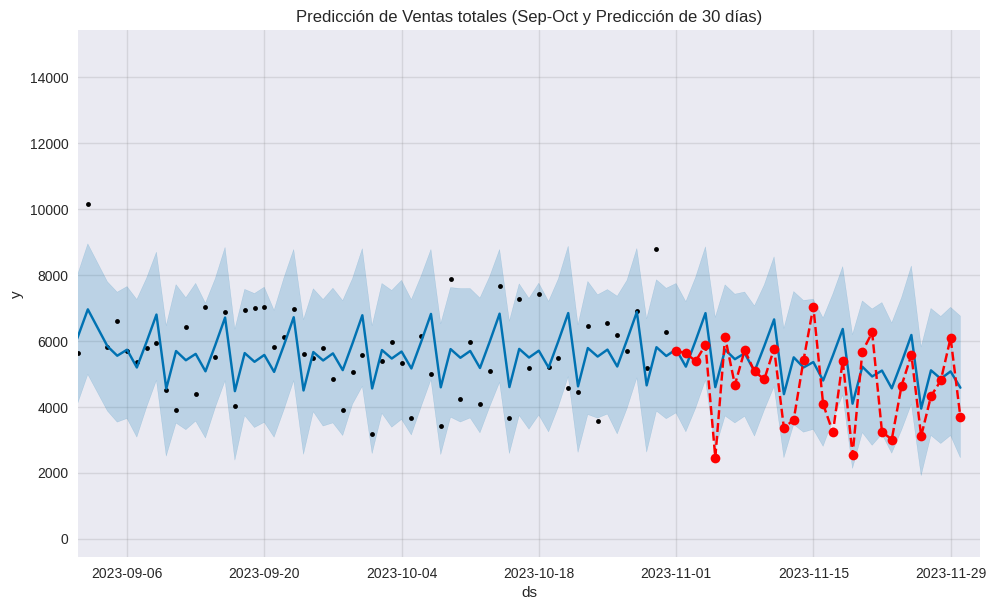

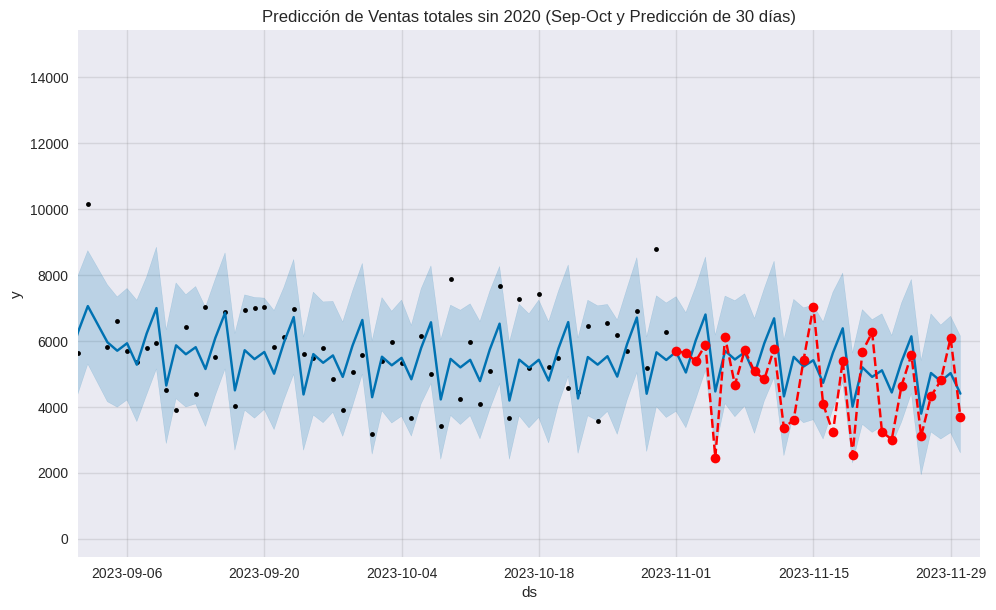

prediccion con todos los valores               ds      yhat
1713 2023-11-01 5739.6116
1714 2023-11-02 5214.8545
1715 2023-11-03 6009.2257
1716 2023-11-04 6837.9289
1717 2023-11-05 4592.4800
1718 2023-11-06 5729.4275
1719 2023-11-07 5441.2526
1720 2023-11-08 5619.6437
1721 2023-11-09 5071.3258
1722 2023-11-10 5842.0902
1723 2023-11-11 6647.6892
1724 2023-11-12 4380.2129
1725 2023-11-13 5496.7941
1726 2023-11-14 5190.4952
1727 2023-11-15 5353.5667
1728 2023-11-16 4793.2626
1729 2023-11-17 5555.8547
1730 2023-11-18 6357.5138
1731 2023-11-19 4090.6739
1732 2023-11-20 5212.7260
1733 2023-11-21 4916.8953
1734 2023-11-22 5095.4929
1735 2023-11-23 4555.7259
1736 2023-11-24 5343.7095
1737 2023-11-25 6175.3488
1738 2023-11-26 3942.7051
1739 2023-11-27 5102.6954
1740 2023-11-28 4847.9783
1741 2023-11-29 5070.2152
1742 2023-11-30 4575.8934
prediccion sin el 2020               ds      yhat
1415 2023-11-01 5666.1033
1416 2023-11-02 5037.3256
1417 2023-11-03 6006.3166
1418 2023-11-04 6795.9848
1419 2

In [148]:
# definir las fechas de inicio y fin
fecha_inicio_str = '2023-09-01'
fecha_fin_str = '2023-12-02'
# Convertir las fechas a objetos datetime
fecha_inicio = datetime.strptime(fecha_inicio_str, '%Y-%m-%d')
fecha_fin = datetime.strptime(fecha_fin_str, '%Y-%m-%d')

# Crear un modelo de Prophet
modelo1 = Prophet()
modelo2 = Prophet()
# Ajustar el modelo con los datos de entrenamiento
modelo1.fit(df_todo_hasta_nov_prophet)
modelo2.fit(df_todo_hasta_nov_sin_2020_prophet)
# Crear un DataFrame con fechas futuras para hacer la predicción
futuro1 = modelo1.make_future_dataframe(periods=30)
futuro2 = modelo2.make_future_dataframe(periods=30)
# Hacer la predicción
prediccion1 = modelo1.predict(futuro1)
prediccion2 = modelo2.predict(futuro2)

# Visualizar la predicción con límites ajustados
fig = modelo1.plot(prediccion1)

plt.plot(df_noviembre_prophet['ds'], df_noviembre_prophet['y'], label='Ventas reales de noviembre', color='red', marker='o', linestyle='dashed')

# Aplicar límites al eje x
plt.xlim([fecha_inicio, fecha_fin])
# Añadir título al gráfico
plt.title(f'Predicción de Ventas totales (Sep-Oct y Predicción de 30 días)')
# Mostrar el gráfico
plt.show()

# Visualizar la predicción con límites ajustados
fig = modelo2.plot(prediccion2)

plt.plot(df_noviembre_prophet['ds'], df_noviembre_prophet['y'], label='Ventas reales de noviembre', color='red', marker='o', linestyle='dashed')

# Aplicar límites al eje x
plt.xlim([fecha_inicio, fecha_fin])
# Añadir título al gráfico
plt.title(f'Predicción de Ventas totales sin 2020 (Sep-Oct y Predicción de 30 días)')
# Mostrar el gráfico
plt.show()


# Extraer los valores reales de predicción para cada día
valores_prediccion1 = prediccion1[['ds', 'yhat']].tail(30)
valores_prediccion2 = prediccion2[['ds', 'yhat']].tail(30)

# Mostrar el DataFrame con los valores de predicción
print("prediccion con todos los valores " , valores_prediccion1)
print("prediccion sin el 2020 " , valores_prediccion2)
# # Visualizar la predicción
# fig = modelo1.plot(prediccion1)
# plt.show()

# fig = modelo2.plot(prediccion2)
# plt.show()

## EVALUACION
Predicciones hechas sobre todas las ventas de los 10 producton contando con y sin las ventas de 2020

evaluacion con 2020

In [151]:
df_noviembre_sumaT = df_noviembre[[
                                    'FechaMovimiento',
                                    'MontoBase',
                                    ]]
df_noviembre_sumaT = df_noviembre_sumaT.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()

print(df_noviembre_sumaT.head(10))
print(df_noviembre_sumaT.dtypes)
print(df_noviembre_sumaT.shape)

df_noviembre_suma_sin_2020 = df_noviembre_sumaT.copy()

  FechaMovimiento  MontoBase
0      2023-11-01  5696.0218
1      2023-11-02  5620.0323
2      2023-11-03  5383.0235
3      2023-11-04  5875.4627
4      2023-11-05  2456.8761
5      2023-11-06  6112.4366
6      2023-11-07  4661.7902
7      2023-11-08  5715.1548
8      2023-11-09  5067.5888
9      2023-11-10  4830.1212
FechaMovimiento     object
MontoBase          float64
dtype: object
(30, 2)


In [152]:
# print(valores_prediccion1.describe)
# print(df_noviembre_sumaT.shape)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [153]:
# Convertir las columnas de fecha a tipo datetime
df_noviembre_sumaT['FechaMovimiento'] = pd.to_datetime(df_noviembre_sumaT['FechaMovimiento'])
valores_prediccion1['ds'] = pd.to_datetime(valores_prediccion1['ds'])

# Fusionar los DataFrames en base a la columna de fecha
df_noviembre_sumaT = pd.merge(df_noviembre_sumaT, valores_prediccion1[['ds', 'yhat']], left_on='FechaMovimiento', right_on='ds', how='left')

# Renombrar la columna yhat a Ventas_PROPHET
df_noviembre_sumaT.rename(columns={'yhat': 'Ventas_PROPHET'}, inplace=True)

# Opcional: Eliminar la columna adicional 'ds' si no la necesitas
df_noviembre_sumaT.drop(columns=['ds'], inplace=True)

# Imprimir el resultado
print(df_noviembre_sumaT.head(50))

   FechaMovimiento  MontoBase  Ventas_PROPHET
0       2023-11-01  5696.0218       5739.6116
1       2023-11-02  5620.0323       5214.8545
2       2023-11-03  5383.0235       6009.2257
3       2023-11-04  5875.4627       6837.9289
4       2023-11-05  2456.8761       4592.4800
5       2023-11-06  6112.4366       5729.4275
6       2023-11-07  4661.7902       5441.2526
7       2023-11-08  5715.1548       5619.6437
8       2023-11-09  5067.5888       5071.3258
9       2023-11-10  4830.1212       5842.0902
10      2023-11-11  5764.7558       6647.6892
11      2023-11-12  3351.1659       4380.2129
12      2023-11-13  3606.4129       5496.7941
13      2023-11-14  5410.0565       5190.4952
14      2023-11-15  7034.1144       5353.5667
15      2023-11-16  4076.0206       4793.2626
16      2023-11-17  3219.5377       5555.8547
17      2023-11-18  5399.8141       6357.5138
18      2023-11-19  2534.1534       4090.6739
19      2023-11-20  5671.3332       5212.7260
20      2023-11-21  6253.0759     

In [154]:
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_PROPHET'])

Evaluation metric results:-
MSE is : 1242383.2159357269
MAE is : 926.7171844244527
R2 is : 0.16207569394523758 %
------------------------------
RMSE is : 1114.6224544372533
MAPE is : 23.85447363339454 %
------------------------------


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


evaluacion sin 2020

In [155]:
# Convertir las columnas de fecha a tipo datetime
df_noviembre_suma_sin_2020['FechaMovimiento'] = pd.to_datetime(df_noviembre_suma_sin_2020['FechaMovimiento'])
valores_prediccion2['ds'] = pd.to_datetime(valores_prediccion2['ds'])

# Fusionar los DataFrames en base a la columna de fecha
df_noviembre_suma_sin_2020 = pd.merge(df_noviembre_suma_sin_2020, valores_prediccion2[['ds', 'yhat']], left_on='FechaMovimiento', right_on='ds', how='left')

# Renombrar la columna yhat a Ventas_PROPHET
df_noviembre_suma_sin_2020.rename(columns={'yhat': 'Ventas_PROPHET'}, inplace=True)

# Opcional: Eliminar la columna adicional 'ds' si no la necesitas
df_noviembre_suma_sin_2020.drop(columns=['ds'], inplace=True)

# Imprimir el resultado
print(df_noviembre_suma_sin_2020.head(20))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   FechaMovimiento  MontoBase  Ventas_PROPHET
0       2023-11-01  5696.0218       5666.1033
1       2023-11-02  5620.0323       5037.3256
2       2023-11-03  5383.0235       6006.3166
3       2023-11-04  5875.4627       6795.9848
4       2023-11-05  2456.8761       4462.5432
5       2023-11-06  6112.4366       5694.2884
6       2023-11-07  4661.7902       5432.9613
7       2023-11-08  5715.1548       5651.3543
8       2023-11-09  5067.5888       4989.7885
9       2023-11-10  4830.1212       5924.7801
10      2023-11-11  5764.7558       6679.9813
11      2023-11-12  3351.1659       4312.3953
12      2023-11-13  3606.4129       5511.1368
13      2023-11-14  5410.0565       5218.7718
14      2023-11-15  7034.1144       5408.9047
15      2023-11-16  4076.0206       4722.6331
16      2023-11-17  3219.5377       5637.1946
17      2023-11-18  5399.8141       6376.8863
18      2023-11-19  2534.1534       3999.2623
19      2023-11-20  5671.3332       5193.8770


In [156]:
evaluacion_metrica(df_noviembre_suma_sin_2020['MontoBase'],df_noviembre_suma_sin_2020['Ventas_PROPHET'])

Evaluation metric results:-
MSE is : 1200197.5509256136
MAE is : 909.2023780861732
R2 is : 0.19052777992454983 %
------------------------------
RMSE is : 1095.5352805481043
MAPE is : 23.183302371968022 %
------------------------------


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# LSTM


In [157]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [158]:
print(df_todo_hasta_nov.head())
print(df_todo_hasta_nov.dtypes)
print(df_todo_hasta_nov.shape)
print("---"*5, "  PROPHET  ", "---"*5)
print(df_todo_hasta_nov_prophet.head())
print(df_todo_hasta_nov_prophet.dtypes)
print(df_todo_hasta_nov_prophet.shape)

             NombreProducto FechaMovimiento  MontoBase  year
1267        FILETE A GRANEL      2018-11-01    47.1960  2018
122360       POLLO ESPECIAL      2018-11-01   120.1500  2018
1266    PIERNA MUSLO OFERTA      2018-11-01    66.2400  2018
1265    PIERNA MUSLO OFERTA      2018-11-01    44.7120  2018
1263                 PIERNA      2018-11-01     5.0600  2018
NombreProducto      object
FechaMovimiento     object
MontoBase          float64
year                 int64
dtype: object
(203613, 4)
---------------   PROPHET   ---------------
           ds         y
0  2018-11-01 2670.9520
1  2018-11-02 4535.6180
2  2018-11-03 2401.9150
3  2018-11-04 2832.0090
4  2018-11-05 4109.9060
ds     object
y     float64
dtype: object
(1713, 2)


In [159]:
df_lstm = df_todo_hasta_nov_prophet.rename(columns={
    'ds': 'FechaMovimiento',
    'y': 'MontoBase'
    })

df_lstm_sin_2020 = df_todo_hasta_nov_sin_2020_prophet.rename(columns={
    'ds': 'FechaMovimiento',
    'y': 'MontoBase'
    })

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [160]:
# Seleccionar las columnas relevantes y convertir 'FechaMovimiento' a tipo datetime
df_lstm = df_lstm[['FechaMovimiento', 'MontoBase']]
df_lstm['FechaMovimiento'] = pd.to_datetime(df_lstm['FechaMovimiento'])

# Establecer la columna de fecha como índice
df_lstm.set_index('FechaMovimiento', inplace=True)

# Preprocesamiento de fechas utilizando el índice
df_lstm['DayOW'] = df_lstm.index.dayofweek
df_lstm['Month'] = df_lstm.index.month
df_lstm['Year'] = df_lstm.index.year

# Ordenar el DataFrame por la fecha
df_lstm.sort_index(inplace=True)

# Muestra el DataFrame resultante
print(df_lstm)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                 MontoBase  DayOW  Month  Year
FechaMovimiento                               
2018-11-01       2670.9520      3     11  2018
2018-11-02       4535.6180      4     11  2018
2018-11-03       2401.9150      5     11  2018
2018-11-04       2832.0090      6     11  2018
2018-11-05       4109.9060      0     11  2018
...                    ...    ...    ...   ...
2023-10-27       5680.5769      4     10  2023
2023-10-28       6896.5590      5     10  2023
2023-10-29       5169.1250      6     10  2023
2023-10-30       8787.0464      0     10  2023
2023-10-31       6261.5983      1     10  2023

[1713 rows x 4 columns]


In [161]:
print(df_lstm)
print(df_lstm.dtypes)
print(df_todo_hasta_nov_prophet)
print(df_todo_hasta_nov_prophet.dtypes)

                 MontoBase  DayOW  Month  Year
FechaMovimiento                               
2018-11-01       2670.9520      3     11  2018
2018-11-02       4535.6180      4     11  2018
2018-11-03       2401.9150      5     11  2018
2018-11-04       2832.0090      6     11  2018
2018-11-05       4109.9060      0     11  2018
...                    ...    ...    ...   ...
2023-10-27       5680.5769      4     10  2023
2023-10-28       6896.5590      5     10  2023
2023-10-29       5169.1250      6     10  2023
2023-10-30       8787.0464      0     10  2023
2023-10-31       6261.5983      1     10  2023

[1713 rows x 4 columns]
MontoBase    float64
DayOW          int64
Month          int64
Year           int64
dtype: object
              ds         y
0     2018-11-01 2670.9520
1     2018-11-02 4535.6180
2     2018-11-03 2401.9150
3     2018-11-04 2832.0090
4     2018-11-05 4109.9060
...          ...       ...
1708  2023-10-27 5680.5769
1709  2023-10-28 6896.5590
1710  2023-10-29 5169.1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [162]:
# print(df_todo.tail(30))
# df_todo.sort_values(by='ds', inplace=True)
# print(df_todo.tail(20))

# Verificar unicidad de fechas
duplicates = df_lstm.index[df_lstm.index.duplicated(keep=False)]
if len(duplicates) > 0:
    print("Hay fechas duplicadas en df_lstm:")
    print(duplicates)
else:
    print("No hay fechas duplicadas en df_lstm.")

No hay fechas duplicadas en df_lstm.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [163]:
df_lstm.describe()
#df_lstm.head

,MontoBase,DayOW,Month,Year
count,1713.0000,1713.0000,1713.0000,1713.0000
mean,5501.0090,2.8815,6.5452,2020.8692
std,1816.8110,1.9609,3.4874,1.4864
min,173.6940,0.0000,1.0000,2018.0000
25%,4361.1950,1.0000,3.0000,2020.0000
50%,5427.4229,3.0000,7.0000,2021.0000
75%,6519.3040,5.0000,10.0000,2022.0000
max,14703.1460,6.0000,12.0000,2023.0000


In [164]:
# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm['MontoBase_scaler'] = scaler.fit_transform(df_lstm['MontoBase'].values.reshape(-1, 1))

# Crear secuencias temporales
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length:i+seq_length+1]
        sequences.append((seq, label))
    return np.array([s[0] for s in sequences]), np.array([s[1] for s in sequences])

seq_length = 30  # ajusta según tus necesidades
X, y = create_sequences(df_lstm['MontoBase_scaler'].values, seq_length)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dividir en entrenamiento y al final toda la prueba

In [165]:
# Dividir en conjuntos de entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dividir en periodos de testeo en medio de la serie temporal

In [167]:
# Reshape para el modelo LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [168]:
# Construir el modelo LSTM
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

# Hacer predicciones en el conjunto de prueba
predictions = model.predict(X_test)

# Desnormalizar las predicciones
predictions = scaler.inverse_transform(predictions)


Epoch 1/50
43/43 - 6s - loss: 0.0300 - 6s/epoch - 149ms/step
Epoch 2/50
43/43 - 2s - loss: 0.0119 - 2s/epoch - 36ms/step
Epoch 3/50
43/43 - 2s - loss: 0.0117 - 2s/epoch - 47ms/step
Epoch 4/50
43/43 - 1s - loss: 0.0117 - 1s/epoch - 29ms/step
Epoch 5/50
43/43 - 1s - loss: 0.0118 - 958ms/epoch - 22ms/step
Epoch 6/50
43/43 - 1s - loss: 0.0116 - 1s/epoch - 24ms/step
Epoch 7/50
43/43 - 1s - loss: 0.0116 - 1s/epoch - 25ms/step
Epoch 8/50
43/43 - 1s - loss: 0.0119 - 1s/epoch - 26ms/step
Epoch 9/50
43/43 - 1s - loss: 0.0115 - 1s/epoch - 24ms/step
Epoch 10/50
43/43 - 1s - loss: 0.0118 - 1s/epoch - 24ms/step
Epoch 11/50
43/43 - 1s - loss: 0.0116 - 1s/epoch - 27ms/step
Epoch 12/50
43/43 - 1s - loss: 0.0115 - 1s/epoch - 24ms/step
Epoch 13/50
43/43 - 1s - loss: 0.0116 - 960ms/epoch - 22ms/step
Epoch 14/50
43/43 - 2s - loss: 0.0116 - 2s/epoch - 42ms/step
Epoch 15/50
43/43 - 2s - loss: 0.0116 - 2s/epoch - 37ms/step
Epoch 16/50
43/43 - 1s - loss: 0.0116 - 1s/epoch - 30ms/step
Epoch 17/50
43/43 - 1s - l

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


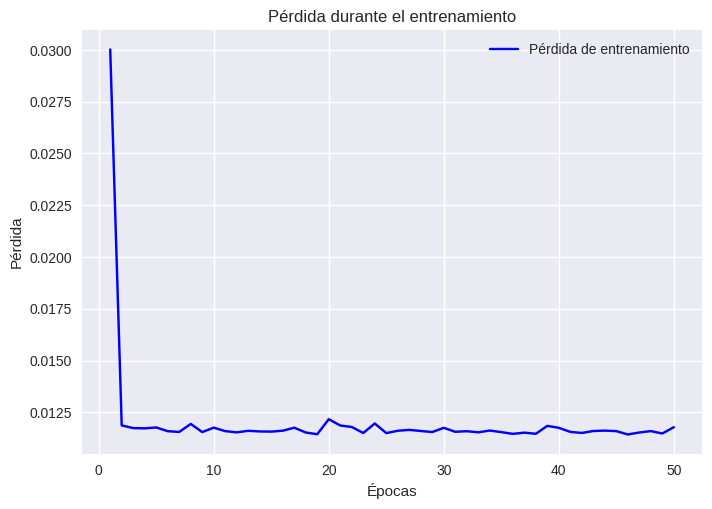

In [169]:
# Recuperar la función de pérdida durante el entrenamiento
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

# Graficar la pérdida durante el entrenamiento
plt.plot(epochs, loss, 'b', label='Pérdida de entrenamiento')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

Error cuadrático medio en el conjunto de prueba: 2350075.530395748


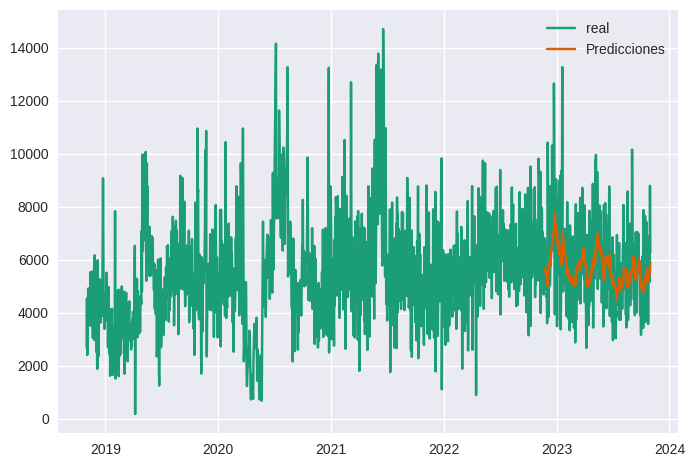

In [170]:
# Calcular el error cuadrático medio en el conjunto de prueba
mse = mean_squared_error(df_lstm['MontoBase'].values[train_size+seq_length:], predictions)
print(f"Error cuadrático medio en el conjunto de prueba: {mse}")

# Visualizar las predicciones
plt.plot(df_lstm['MontoBase'], label='real')
plt.plot(df_lstm.index[train_size+seq_length:], predictions, label='Predicciones')
plt.legend()
plt.show()

In [171]:
# Verificar la forma de los datos
print("Forma de X:", X.shape)
print("Forma de y:", y.shape)

Forma de X: (1683, 30)
Forma de y: (1683, 1)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1/1 [==============================] - 0s 40ms/step


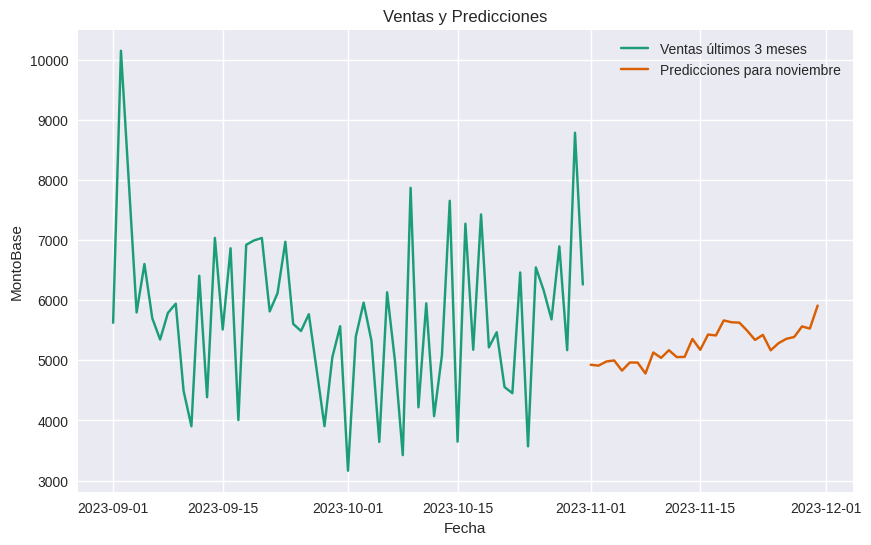

In [172]:
# Supongamos que df_lstm tiene la columna 'FechaMovimiento' como índice
df_lstm.index = pd.to_datetime(df_lstm.index)

# Paso 1: Preparar datos de entrada para las predicciones
last_3_months = df_lstm[df_lstm.index >= '2023-09-01']  # Ajusta la fecha según tu necesidad
input_data = last_3_months['MontoBase'].values
input_data = scaler.transform(input_data.reshape(-1, 1))
input_data, _ = create_sequences(input_data, seq_length)
input_data = input_data.reshape((input_data.shape[0], input_data.shape[1], 1))

# Paso 2: Hacer predicciones para los siguientes 30 días
predictions_future = model.predict(input_data)

# Desnormalizar las predicciones
predictions_future = scaler.inverse_transform(predictions_future)

# Paso 3: Visualizar los resultados
plt.figure(figsize=(10, 6))

# Datos de ventas de los últimos 3 meses
plt.plot(last_3_months.index, last_3_months['MontoBase'], label='Ventas últimos 3 meses')

# Predicciones para noviembre de 2023
dates_future = pd.date_range(start='2023-11-01', periods=len(predictions_future))
plt.plot(dates_future, predictions_future, label='Predicciones para noviembre')

plt.title('Ventas y Predicciones')
plt.xlabel('Fecha')
plt.ylabel('MontoBase')
plt.legend()
plt.show()

### Evaluar

In [173]:
# Suponiendo que df_noviembre_sumaT y predictions_future están en el mismo orden
df_noviembre_sumaT['Ventas_LSTM'] = predictions_future

# Imprimir el resultado
print(df_noviembre_sumaT.head(20))

   FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM
0       2023-11-01  5696.0218       5739.6116    4926.2163
1       2023-11-02  5620.0323       5214.8545    4911.6436
2       2023-11-03  5383.0235       6009.2257    4979.9668
3       2023-11-04  5875.4627       6837.9289    4998.0054
4       2023-11-05  2456.8761       4592.4800    4828.6982
5       2023-11-06  6112.4366       5729.4275    4963.7563
6       2023-11-07  4661.7902       5441.2526    4962.3066
7       2023-11-08  5715.1548       5619.6437    4781.1055
8       2023-11-09  5067.5888       5071.3258    5130.3101
9       2023-11-10  4830.1212       5842.0902    5041.3545
10      2023-11-11  5764.7558       6647.6892    5168.3281
11      2023-11-12  3351.1659       4380.2129    5053.6553
12      2023-11-13  3606.4129       5496.7941    5057.0259
13      2023-11-14  5410.0565       5190.4952    5355.1895
14      2023-11-15  7034.1144       5353.5667    5174.7471
15      2023-11-16  4076.0206       4793.2626    5429.09

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [174]:
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_LSTM'])

Evaluation metric results:-
MSE is : 1946269.77425365
MAE is : 1112.5641776302082
R2 is : -0.3126599981943232 %
------------------------------
RMSE is : 1395.0877299487836
MAPE is : 30.24273735699703 %
------------------------------


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## SIN 2020

In [175]:
# Seleccionar las columnas relevantes y convertir 'FechaMovimiento' a tipo datetime
df_lstm_sin_2020 = df_lstm_sin_2020[['FechaMovimiento', 'MontoBase']]
df_lstm_sin_2020['FechaMovimiento'] = pd.to_datetime(df_lstm_sin_2020['FechaMovimiento'])

# Establecer la columna de fecha como índice
df_lstm_sin_2020.set_index('FechaMovimiento', inplace=True)

# Preprocesamiento de fechas utilizando el índice
df_lstm_sin_2020['DayOW'] = df_lstm_sin_2020.index.dayofweek
df_lstm_sin_2020['Month'] = df_lstm_sin_2020.index.month
df_lstm_sin_2020['Year'] = df_lstm_sin_2020.index.year

# Ordenar el DataFrame por la fecha
df_lstm_sin_2020.sort_index(inplace=True)

# Muestra el DataFrame resultante
print(df_lstm_sin_2020)

# Normalizar los datos
scaler_2 = MinMaxScaler(feature_range=(0, 1))
df_lstm_sin_2020['MontoBase_scaler'] = scaler_2.fit_transform(df_lstm_sin_2020['MontoBase'].values.reshape(-1, 1))

# Crear secuencias temporales
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length:i+seq_length+1]
        sequences.append((seq, label))
    return np.array([s[0] for s in sequences]), np.array([s[1] for s in sequences])

seq_length = 30  # ajusta según tus necesidades
X, y = create_sequences(df_lstm_sin_2020['MontoBase_scaler'].values, seq_length)


# Dividir en conjuntos de entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# Reshape para el modelo LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Construir el modelo LSTM
model_2 = Sequential()
model_2.add(LSTM(units=50, input_shape=(X_train.shape[1], 1)))
model_2.add(Dense(units=1))
model_2.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history_2 = model_2.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

# Hacer predicciones en el conjunto de prueba
predictions_2 = model_2.predict(X_test)

# Desnormalizar las predicciones
predictions_2 = scaler_2.inverse_transform(predictions_2)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                 MontoBase  DayOW  Month  Year
FechaMovimiento                               
2018-11-01       2670.9520      3     11  2018
2018-11-02       4535.6180      4     11  2018
2018-11-03       2401.9150      5     11  2018
2018-11-04       2832.0090      6     11  2018
2018-11-05       4109.9060      0     11  2018
...                    ...    ...    ...   ...
2023-10-27       5680.5769      4     10  2023
2023-10-28       6896.5590      5     10  2023
2023-10-29       5169.1250      6     10  2023
2023-10-30       8787.0464      0     10  2023
2023-10-31       6261.5983      1     10  2023

[1415 rows x 4 columns]
Epoch 1/50
35/35 - 4s - loss: 0.0444 - 4s/epoch - 110ms/step
Epoch 2/50
35/35 - 1s - loss: 0.0120 - 866ms/epoch - 25ms/step
Epoch 3/50
35/35 - 1s - loss: 0.0118 - 727ms/epoch - 21ms/step
Epoch 4/50
35/35 - 1s - loss: 0.0117 - 727ms/epoch - 21ms/step
Epoch 5/50
35/35 - 1s - loss: 0.0116 - 792ms/epoch - 23ms/step
Epoch 6/50
35/35 - 1s - loss: 0.0116 - 807ms/epoch 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


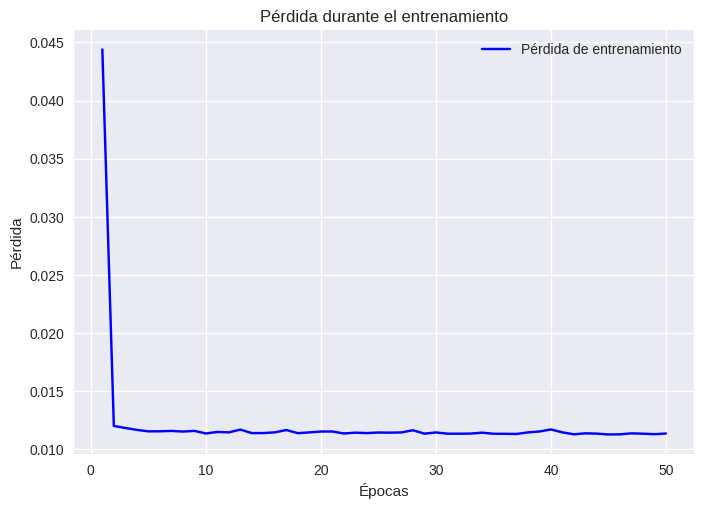

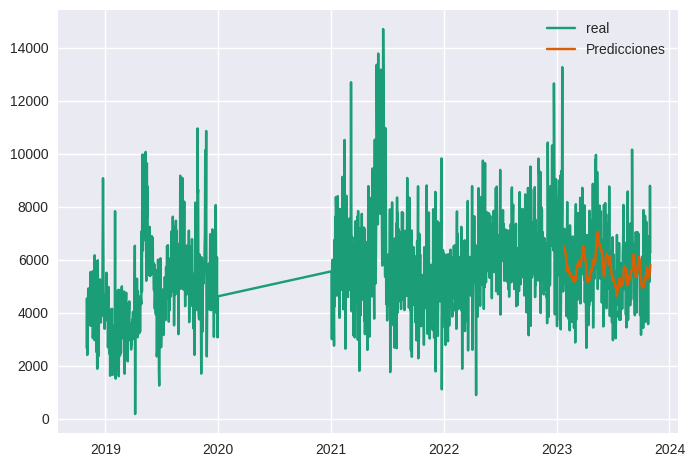

In [176]:
# Recuperar la función de pérdida durante el entrenamiento
loss_2 = history_2.history['loss']
epochs_2 = range(1, len(loss_2) + 1)

# Graficar la pérdida durante el entrenamiento
plt.plot(epochs_2, loss_2, 'b', label='Pérdida de entrenamiento')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


# Visualizar las predicciones
plt.plot(df_lstm_sin_2020['MontoBase'], label='real')
plt.plot(df_lstm_sin_2020.index[train_size+seq_length:], predictions_2, label='Predicciones')
plt.legend()
plt.show()


Forma de X: (1385, 30)
Forma de y: (1385, 1)
1/1 [==============================] - 0s 24ms/step


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


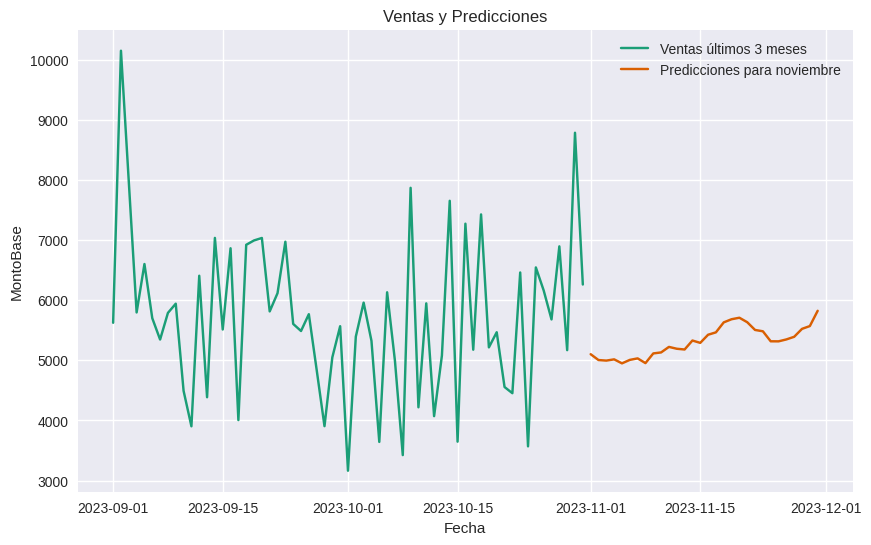

In [177]:
# Verificar la forma de los datos
print("Forma de X:", X.shape)
print("Forma de y:", y.shape)

# Supongamos que df_lstm_sin_2020 tiene la columna 'FechaMovimiento' como índice
df_lstm_sin_2020.index = pd.to_datetime(df_lstm_sin_2020.index)

# Paso 1: Preparar datos de entrada para las predicciones
last_3_months = df_lstm_sin_2020[df_lstm_sin_2020.index >= '2023-09-01']  # Ajusta la fecha según tu necesidad
input_data = last_3_months['MontoBase'].values
input_data = scaler.transform(input_data.reshape(-1, 1))
input_data, _ = create_sequences(input_data, seq_length)
input_data = input_data.reshape((input_data.shape[0], input_data.shape[1], 1))

# Paso 2: Hacer predicciones para los siguientes 30 días
predictions_2_future = model_2.predict(input_data)

# Desnormalizar las predicciones
predictions_2_future = scaler.inverse_transform(predictions_2_future)

# Paso 3: Visualizar los resultados
plt.figure(figsize=(10, 6))

# Datos de ventas de los últimos 3 meses
plt.plot(last_3_months.index, last_3_months['MontoBase'], label='Ventas últimos 3 meses')

# Predicciones para noviembre de 2023
dates_future = pd.date_range(start='2023-11-01', periods=len(predictions_2_future))
plt.plot(dates_future, predictions_2_future, label='Predicciones para noviembre')

plt.title('Ventas y Predicciones')
plt.xlabel('Fecha')
plt.ylabel('MontoBase')
plt.legend()
plt.show()

### Evaluar

In [178]:
# Suponiendo que df_noviembre_sumaT y predictions_future están en el mismo orden
df_noviembre_suma_sin_2020['Ventas_LSTM'] = predictions_2_future

# Imprimir el resultado
print(df_noviembre_sumaT.head(20))

   FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM
0       2023-11-01  5696.0218       5739.6116    4926.2163
1       2023-11-02  5620.0323       5214.8545    4911.6436
2       2023-11-03  5383.0235       6009.2257    4979.9668
3       2023-11-04  5875.4627       6837.9289    4998.0054
4       2023-11-05  2456.8761       4592.4800    4828.6982
5       2023-11-06  6112.4366       5729.4275    4963.7563
6       2023-11-07  4661.7902       5441.2526    4962.3066
7       2023-11-08  5715.1548       5619.6437    4781.1055
8       2023-11-09  5067.5888       5071.3258    5130.3101
9       2023-11-10  4830.1212       5842.0902    5041.3545
10      2023-11-11  5764.7558       6647.6892    5168.3281
11      2023-11-12  3351.1659       4380.2129    5053.6553
12      2023-11-13  3606.4129       5496.7941    5057.0259
13      2023-11-14  5410.0565       5190.4952    5355.1895
14      2023-11-15  7034.1144       5353.5667    5174.7471
15      2023-11-16  4076.0206       4793.2626    5429.09

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [179]:
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_LSTM'])

Evaluation metric results:-
MSE is : 1946269.77425365
MAE is : 1112.5641776302082
R2 is : -0.3126599981943232 %
------------------------------
RMSE is : 1395.0877299487836
MAPE is : 30.24273735699703 %
------------------------------


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# ARIMA

In [180]:
!pip install pmdarima

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [181]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

from pmdarima.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [182]:
df_todo_hasta_nov_prophet.head()

,ds,y
0,2018-11-01,2670.9520
1,2018-11-02,4535.6180
2,2018-11-03,2401.9150
3,2018-11-04,2832.0090
4,2018-11-05,4109.9060


## CON 2020

In [184]:
df_arima = df_todo_hasta_nov_prophet.rename(columns={
    'ds': 'FechaMovimiento',
    'y': 'MontoBase'
    })


# Establecer la columna 'FechaMovimiento' como índice
df_arima.set_index('FechaMovimiento', inplace=True)
# # Dejar la columna 'FechaMovimiento' como tipo fecha
#df_arima['FechaMovimiento'] = pd.to_datetime(df_arima['FechaMovimiento'])

print(df_arima.dtypes)
print(df_arima.head)

MontoBase    float64
dtype: object
<bound method NDFrame.head of                  MontoBase
FechaMovimiento           
2018-11-01       2670.9520
2018-11-02       4535.6180
2018-11-03       2401.9150
2018-11-04       2832.0090
2018-11-05       4109.9060
...                    ...
2023-10-27       5680.5769
2023-10-28       6896.5590
2023-10-29       5169.1250
2023-10-30       8787.0464
2023-10-31       6261.5983

[1713 rows x 1 columns]>


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [185]:
df_arima.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1713 entries, 2018-11-01 to 2023-10-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MontoBase  1713 non-null   float64
dtypes: float64(1)
memory usage: 26.8+ KB


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Identificar si los datos son estacionarios o no


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


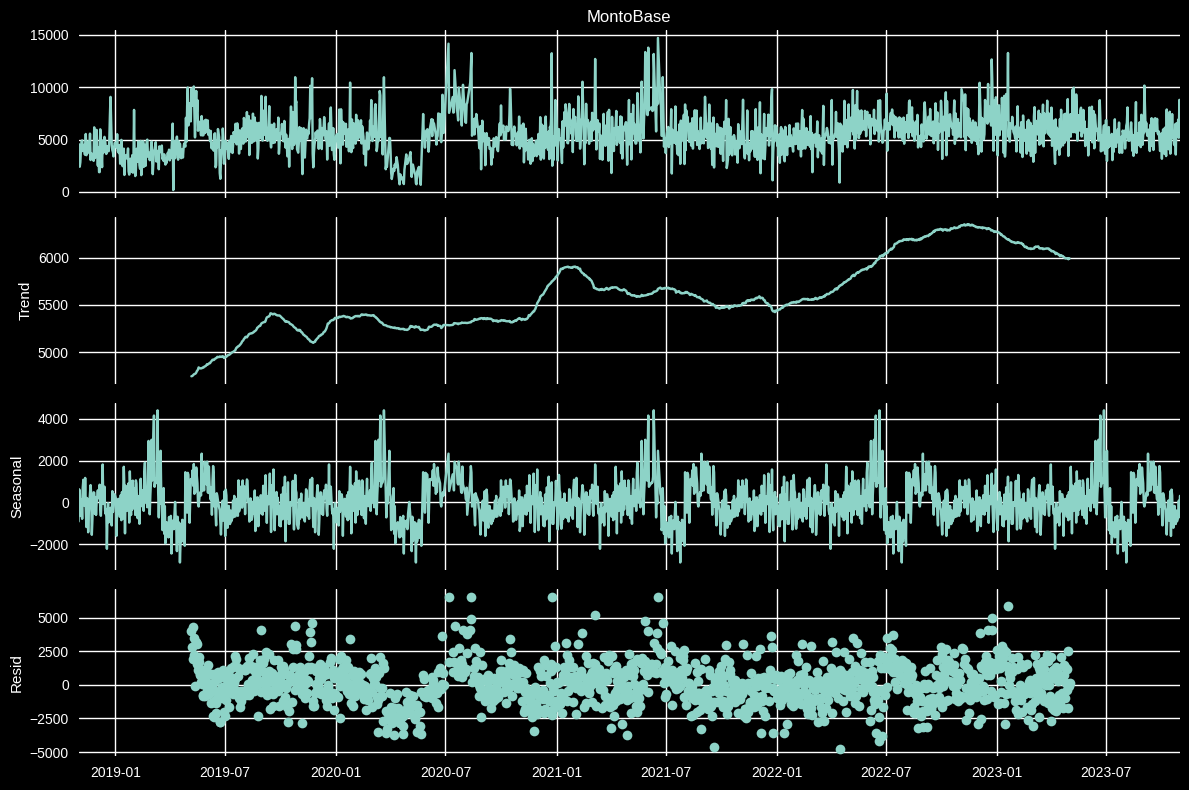

In [186]:
#plt.style.use('seaborn')
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (12, 8)
a = seasonal_decompose(df_arima["MontoBase"], model = "add", period=365)
a.plot();

In [187]:
df_arima

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,MontoBase
FechaMovimiento,
2018-11-01,2670.9520
2018-11-02,4535.6180
2018-11-03,2401.9150
2018-11-04,2832.0090
2018-11-05,4109.9060
...,...
2023-10-27,5680.5769
2023-10-28,6896.5590
2023-10-29,5169.1250


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


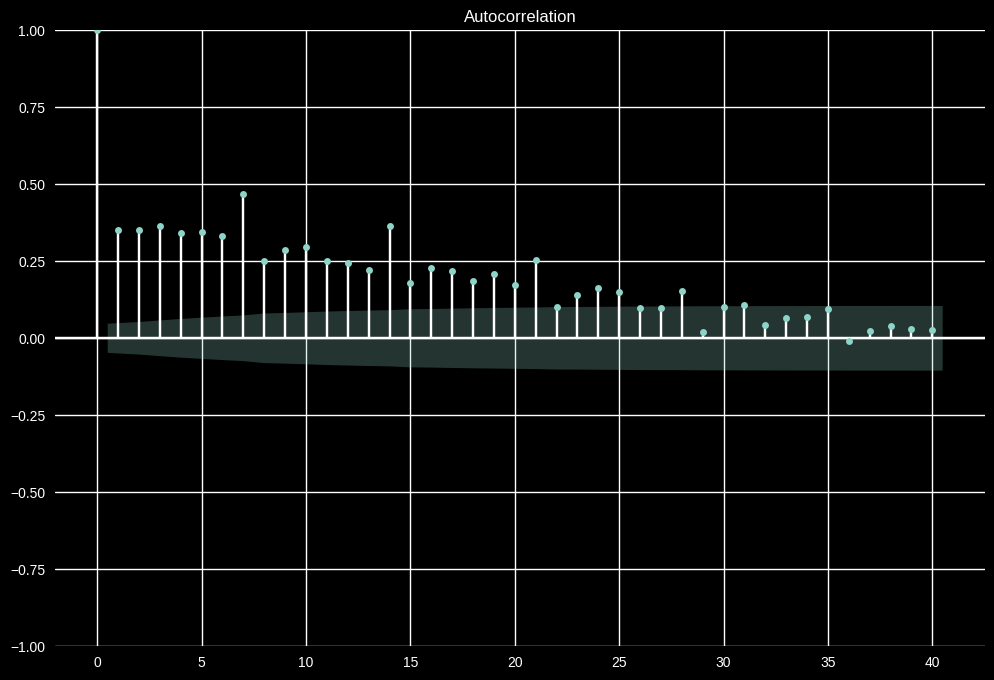

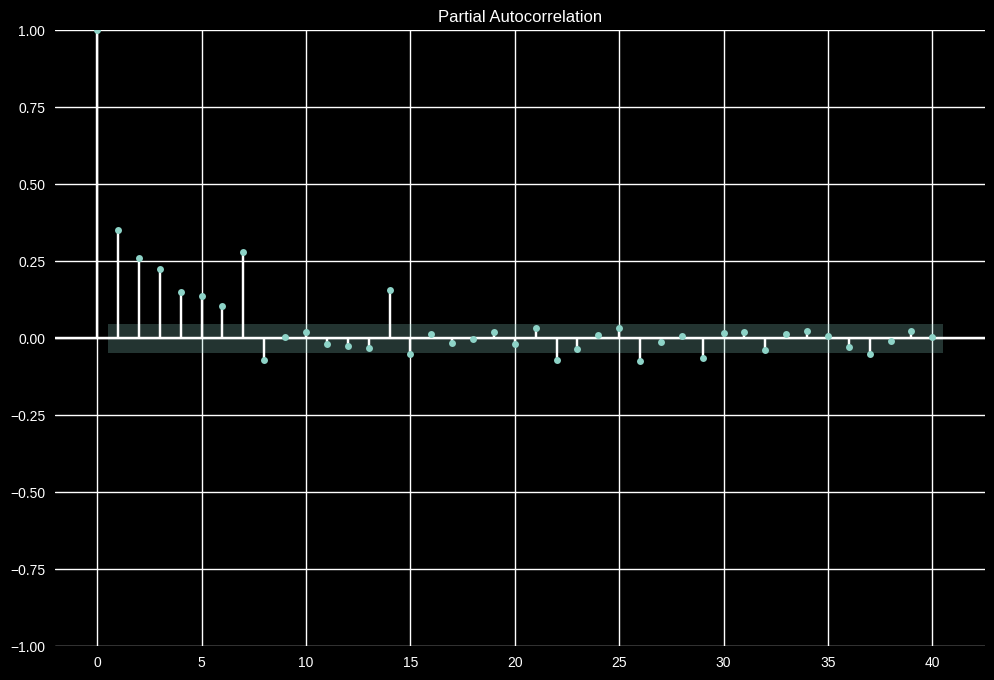

In [188]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
# Dejar la columna 'FechaMovimiento' como tipo fecha
df_arima=df_arima.reset_index()

# Convertir 'FechaMovimiento' a tipo datetime si aún no lo has hecho
df_arima['FechaMovimiento'] = pd.to_datetime(df_arima['FechaMovimiento'])

# Establecer la columna de fecha como índice
df_arima.set_index('FechaMovimiento', inplace=True)

# Visualizar ACF y PACF
plt.style.use('dark_background')
plot_acf(df_arima['MontoBase'], lags=40)
plt.show()

plot_pacf(df_arima['MontoBase'], lags=40)
plt.show()

### prueba de Dickey-Fuller

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


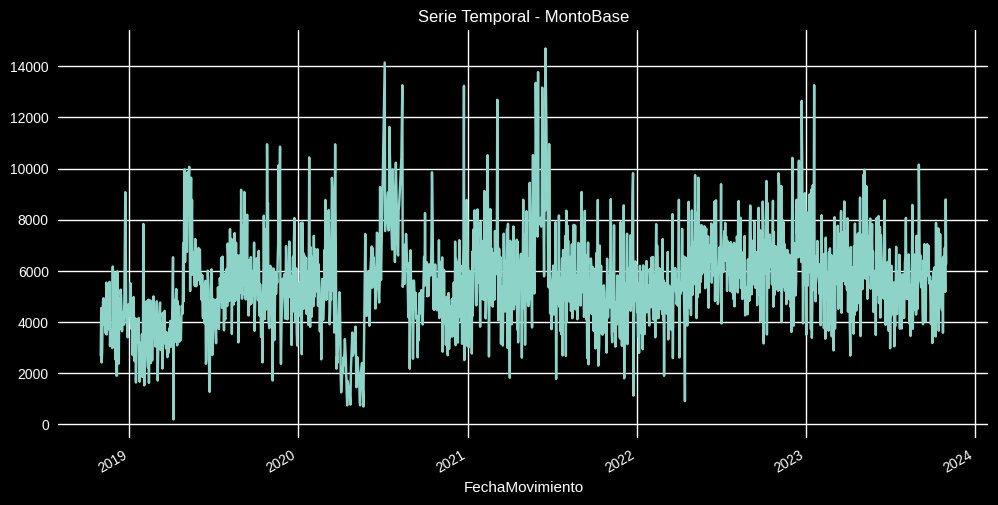

count    1713.0000
mean     5501.0090
std      1816.8110
min       173.6940
25%      4361.1950
50%      5427.4229
75%      6519.3040
max     14703.1460
Name: MontoBase, dtype: float64
Estadística de la prueba de Dickey-Fuller: -5.620098787225558
P-valor: 1.150347635295638e-06
Valores críticos: {'1%': -3.4342322039823197, '5%': -2.863254774066211, '10%': -2.5676829016514233}


In [189]:
# 1. Visualización de la Serie Temporal
df_arima['MontoBase'].plot(figsize=(12, 6))
plt.title('Serie Temporal - MontoBase')
plt.show()

# 2. Estadísticas Descriptivas
print(df_arima['MontoBase'].describe())

# 3. Prueba de Dickey-Fuller
result = adfuller(df_arima['MontoBase'])
print(f'Estadística de la prueba de Dickey-Fuller: {result[0]}')
print(f'P-valor: {result[1]}')
print(f'Valores críticos: {result[4]}')

In [190]:
def Prueba_Dickey_Fuller(series , column_name):
    print (f'Resultados de la prueba de Dickey-Fuller para columna: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Número de observaciones utilizadas'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Rechazar la hipótesis nula")
        print("Los datos son estacionarios")
    else:
        print("Conclusion:====>")
        print("No se puede rechazar la hipótesis nula")
        print("Los datos no son estacionarios")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [191]:
Prueba_Dickey_Fuller(df_arima["MontoBase"],"MontoBase")

Resultados de la prueba de Dickey-Fuller para columna: MontoBase
Test Statistic                         -5.6201
p-value                                 0.0000
No Lags Used                           25.0000
Número de observaciones utilizadas   1687.0000
Critical Value (1%)                    -3.4342
Critical Value (5%)                    -2.8633
Critical Value (10%)                   -2.5677
dtype: float64
Conclusion:====>
Rechazar la hipótesis nula
Los datos son estacionarios


### Dividir en train y test

In [192]:
# # dividir en orden cronologico, un 80% para entrenamiento
# train_size = int(len(df_arima) * 0.8)
# train, test = df_arima[0:train_size], df_arima[train_size:]


# dividir en orden cronologico, entrenando sin el mes de octubre
train_size = int(len(df_arima) - 31)
train, test = df_arima[0:train_size], df_arima[train_size:]

# Divide los datos en entrenamiento y prueba
# # Asegúrate de tener una columna de fecha (DatetimeIndex) en tu DataFrame
# y = df_arima['MontoBase']

# # Especifica el tamaño del conjunto de entrenamiento
# train_size = len(y) - 30

# # Divide los datos en entrenamiento y prueba
# train, test = train_test_split(y, train_size=train_size)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [193]:
train.shape, test.shape

((1682, 1), (31, 1))

### más pruebas


In [194]:
# display(df_arima.head(10))
# #df_arima = df_arima.set_index('FechaMovimiento')
# df_arima = df_arima.asfreq('D')
# display(df_arima.head(10))
# #df_arima = df_arima.asfreq(None)

In [195]:
print(df_arima.isnull().sum())

MontoBase    0
dtype: int64


In [196]:
df_arima = df_arima.dropna()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Test estacionariedad serie original
-------------------------------------


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ADF Statistic: -5.620098787225558, p-value: 1.150347635295638e-06
KPSS Statistic: 1.3830183546675905, p-value: 0.01

Test estacionariedad para serie diferenciada (order=1)
--------------------------------------------------
ADF Statistic: -9.70988824463979, p-value: 1.0182307921717335e-16
KPSS Statistic: 0.07262091742562218, p-value: 0.1

Test estacionariedad para serie diferenciada (order=2)
--------------------------------------------------
ADF Statistic: -16.57517134099375, p-value: 1.855159454539854e-29
KPSS Statistic: 0.01041523748864449, p-value: 0.1


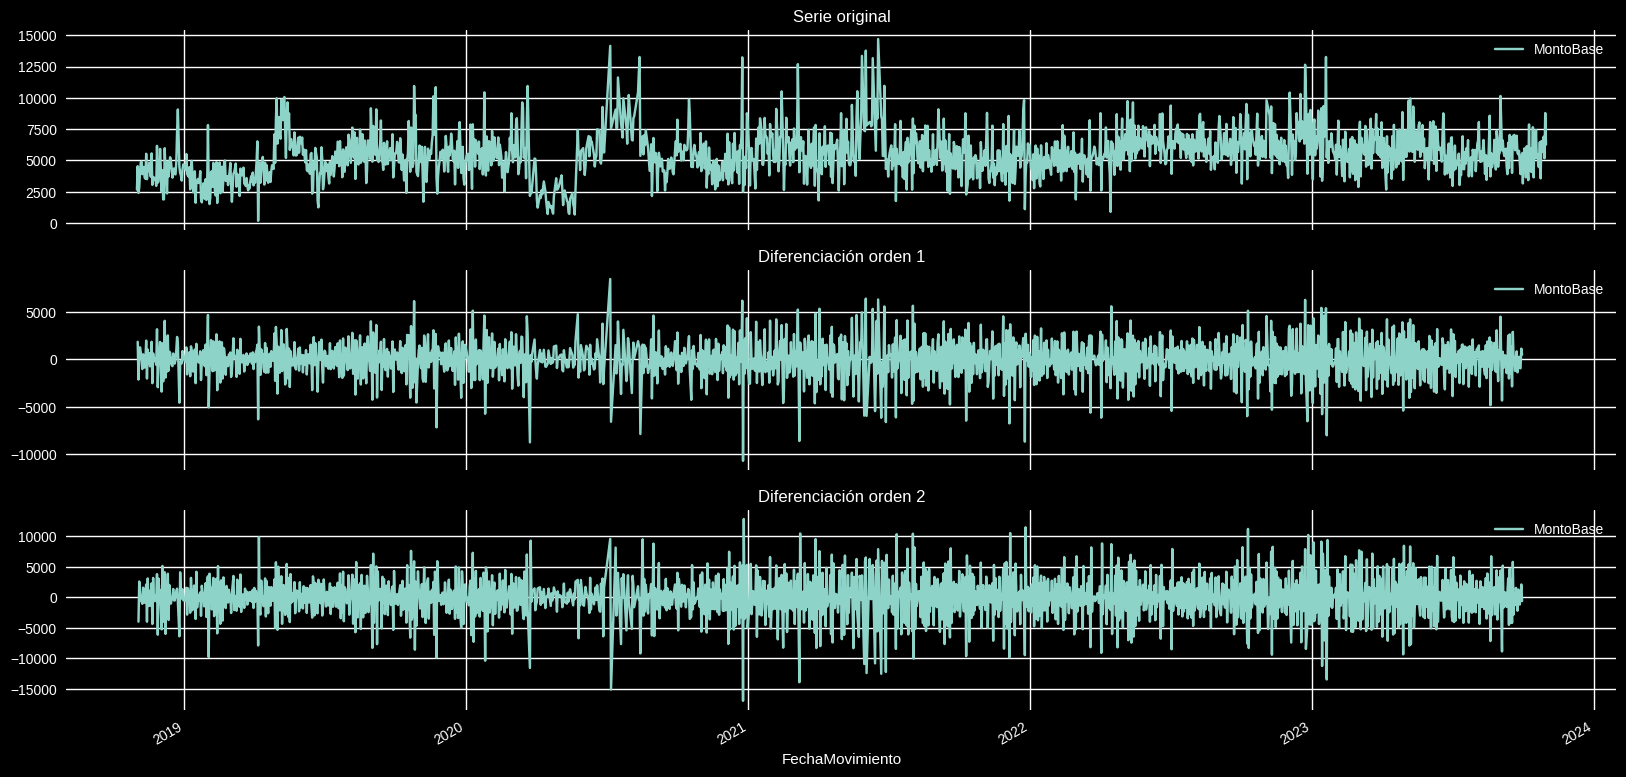

In [197]:

from statsmodels.tsa.stattools import kpss
import warnings
# Test estacionariedad
# ==============================================================================
warnings.filterwarnings("ignore")

df_arima_diff_1 = train.diff().dropna()
df_arima_diff_2 = df_arima_diff_1.diff().dropna()

print('Test estacionariedad serie original')
print('-------------------------------------')
adfuller_result = adfuller(df_arima)
kpss_result = kpss(df_arima)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(df_arima_diff_1)
kpss_result = kpss(df_arima.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(df_arima_diff_2)
kpss_result = kpss(df_arima.diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

warnings.filterwarnings("default")

# Gráfico series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(20, 10), sharex=True)
df_arima.plot(ax=axs[0], title='Serie original')
df_arima_diff_1.plot(ax=axs[1], title='Diferenciación orden 1')
df_arima_diff_2.plot(ax=axs[2], title='Diferenciación orden 2');

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


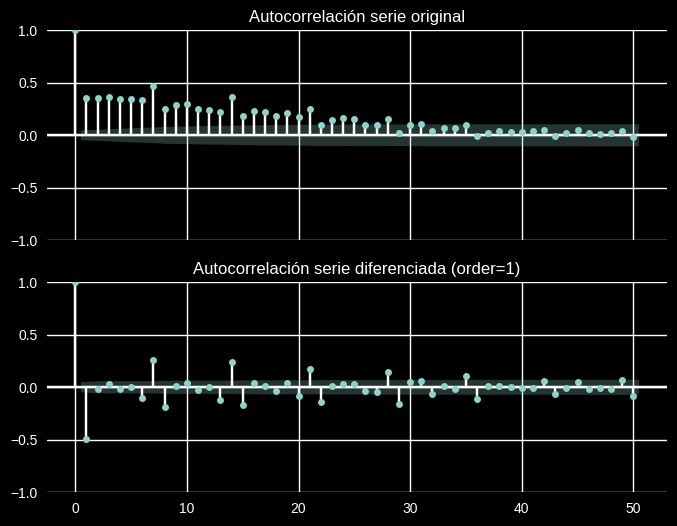

In [198]:
# Grafico de autocorrelación para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), sharex=True)
plot_acf(df_arima, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación serie original')
plot_acf(df_arima_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelación serie diferenciada (order=1)');

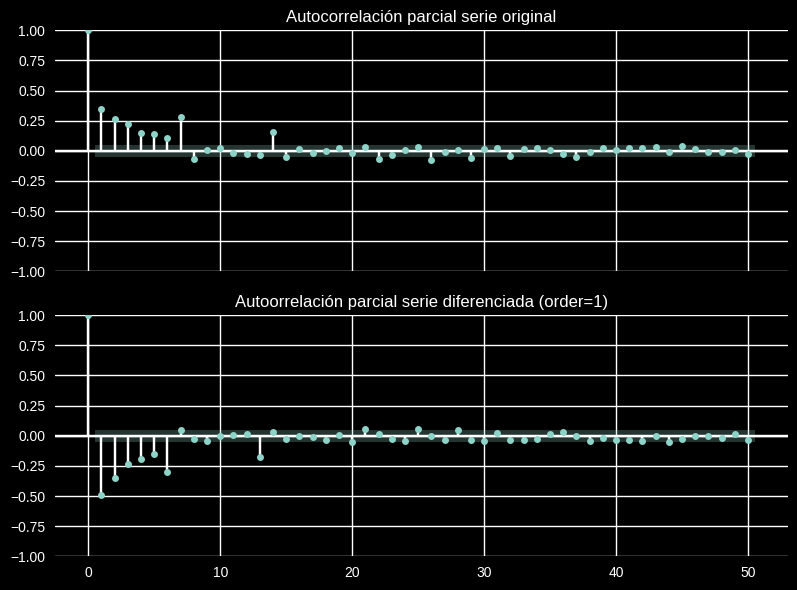

In [199]:
# Autocorrelación parcial para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), sharex=True)
plot_pacf(df_arima, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación parcial serie original')
plot_pacf(df_arima_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autoorrelación parcial serie diferenciada (order=1)');
plt.tight_layout();

In [200]:
# # Asegurarse de que df_arima sea una serie temporal y no un DataFrame
# #df_arima = df_arima['MontoBase']

# # Descomposición de la serie original
# res_decompose = seasonal_decompose(df_arima, model='additive', extrapolate_trend='freq', period=365)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [201]:
# # Descomposición de la serie original y la serie diferenciada
# # ==============================================================================
# #res_decompose = seasonal_decompose(df_arima, model='additive', extrapolate_trend='freq')

# res_descompose_diff_2 = seasonal_decompose(df_arima_diff_1, model='additive', extrapolate_trend='freq', period=365)

# fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)
# res_decompose.observed.plot(ax=axs[0, 0])
# axs[0, 0].set_title('Serie original')
# res_decompose.trend.plot(ax=axs[1, 0])
# axs[1, 0].set_title('Tendencia')
# res_decompose.seasonal.plot(ax=axs[2, 0])
# axs[2, 0].set_title('Estacionalidad')
# res_decompose.resid.plot(ax=axs[3, 0])
# axs[3, 0].set_title('Residuos')
# res_descompose_diff_2.observed.plot(ax=axs[0, 1])
# axs[0, 1].set_title('Series diferenciadas (order=1)')
# res_descompose_diff_2.trend.plot(ax=axs[1, 1])
# axs[1, 1].set_title('Tendencia')
# res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
# axs[2, 1].set_title('Estacionalidad')
# res_descompose_diff_2.resid.plot(ax=axs[3, 1])
# axs[3, 1].set_title('Residuos')
# fig.suptitle('Descomposición de la serie original vs serie diferenciada', fontsize=14)
# fig.tight_layout();

In [202]:
# Diferenciaciación de orden 1 combinada con diferenciación estacional
# ==============================================================================
df_arima_diff_1_12 = train.diff().diff(12).dropna()

warnings.filterwarnings("ignore")
adfuller_result = adfuller(df_arima_diff_1_12)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
kpss_result = kpss(df_arima_diff_1_12)
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
warnings.filterwarnings("default")

ADF Statistic: -12.392264861565598, p-value: 4.759948460208135e-23
KPSS Statistic: 0.032445223491307566, p-value: 0.1


### auto_arima


In [206]:
# Modelo Auto-Arima
from pmdarima import auto_arima

In [207]:
# posibles valores para m = 7_diarios, 12_mensuales, 52_semanales
modelo_auto=auto_arima(train,start_p=0,d=1,start_q=0,
          max_p=4,max_d=2,max_q=4, start_P=0,
          D=1, start_Q=0, max_P=2,max_D=1,
          max_Q=2, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)
print(modelo_auto)
# ## se tiene el problema de q se usa toda la memoria RAM 12.7GB cuando se tiene m=365 (supuestamente periodos anuales)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=31370.694, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=30387.567, Time=7.56 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=7.90 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=31041.177, Time=0.30 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=30272.568, Time=15.86 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=23.97 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=8.74 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=30767.512, Time=2.31 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=30090.483, Time=19.06 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=30208.499, Time=9.21 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=30.84 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=12.53 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=29999.346, Time=19.33 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=30124.184, Time=9.94 sec
 ARIMA(3,1,0)(2,1,1)[12]     

In [208]:
# print(modelo_auto.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 1682
Model:             SARIMAX(4, 1, 0)x(2, 1, 0, 12)   Log Likelihood              -14963.726
Date:                            Thu, 22 Feb 2024   AIC                          29941.451
Time:                                    18:06:42   BIC                          29979.391
Sample:                                         0   HQIC                         29955.510
                                           - 1682                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7940      0.021    -37.469      0.000      -0.835      -0.752
ar.L2         -0.5727      0.026   

### implementación del modelo

In [209]:
print(train)

                 MontoBase
FechaMovimiento           
2018-11-01       2670.9520
2018-11-02       4535.6180
2018-11-03       2401.9150
2018-11-04       2832.0090
2018-11-05       4109.9060
...                    ...
2023-09-26       5767.9455
2023-09-27       4841.5821
2023-09-28       3904.1615
2023-09-29       5049.1239
2023-09-30       5567.5508

[1682 rows x 1 columns]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<ipython-input-242-a09ff01a70ab>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


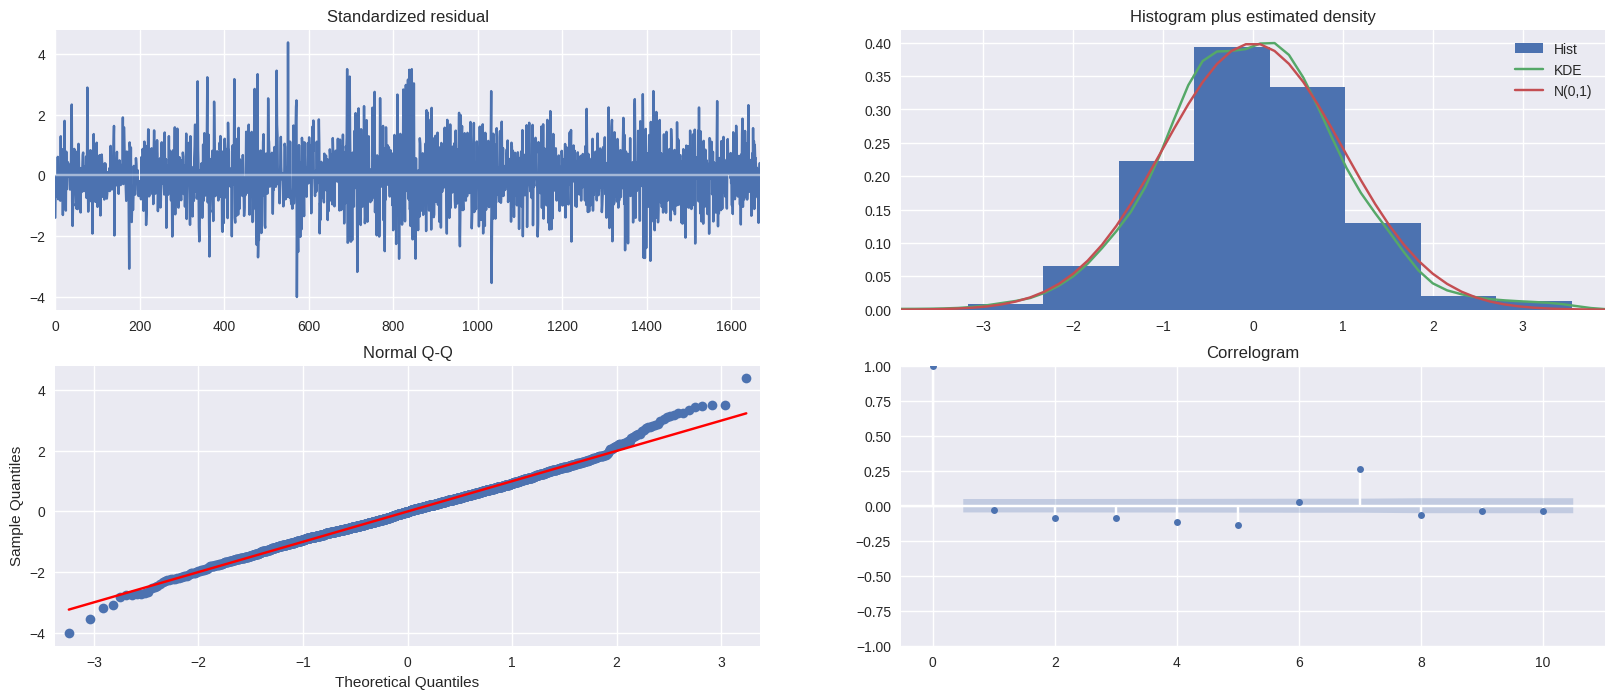

In [242]:
plt.style.use('seaborn')
modelo_auto.plot_diagnostics(figsize=(20,8))
plt.show()

In [243]:
# primera sucursal
# arima_model = SARIMAX(train["MontoBase"], order = (3,1,1), seasonal_order = (2,1,0,12))
# segunda sucursal
arima_model = SARIMAX(train["MontoBase"], order = (4,1,1), seasonal_order = (2,1,0,12))
# tercera sucursal
#
arima_result = arima_model.fit()
warnings.filterwarnings("default")
arima_result.summary()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           MontoBase   No. Observations:                 1682
Model:             SARIMAX(4, 1, 1)x(2, 1, [], 12)   Log Likelihood              -14921.885
Date:                             Thu, 22 Feb 2024   AIC                          29859.770
Time:                                     18:20:42   BIC                          29903.130
Sample:                                          0   HQIC                         29875.836
                                            - 1682                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1466      0.022      6.756      0.000       0.104       0.189
ar.L2          0.1462      0.024      6.075      0.000       0.099       0.193
ar.L3          0.1504      0.022      6.753      0.000       0.107       0.194
ar.L4          0.1273      0.024      5.223      0.000       0.080       0.175
ma.L1         -0.9998      0.034    -28.982      0.000      -1.067      -0.932
ar.S.L12      -0.6349      0.024    -26.803      0.000      -0.681      -0.589
ar.S.L24      -0.2468      0.024    -10.276      0.000      -0.294      -0.200
sigma2      3.397e+06    1.5e+05     22.663      0.000     3.1e+06    3.69e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):               148.69
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             0.41
Prob(H) (two-sided):                  0.47   Kurtosis:                         4.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Pruebas de modelos ARIMA pero diferentes

In [244]:
# # Modelo SARIMAX con statsmodels.Sarimax
# # ==============================================================================
# warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
# modelo = SARIMAX(endog = train["MontoBase"], order = (1, 1, 1), seasonal_order = (1, 1, 1, 12))
# modelo_res = modelo.fit(disp=0)
# warnings.filterwarnings("default")
# modelo_res.summary()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [245]:
# import statsmodels as sm
# # Esta es la forma del modelo, para utilizar menos memoria y un nuevo metodo
# # mod = sm.tsa.arima.ARIMA(endog, order=(p, d, q), seasonal_order=(P, D, Q, 365))
# # res = mod.fit(method='innovations_mle', low_memory=True, cov_type='none')
# mod = sm.tsa.arima.model.ARIMA(train["MontoBase"], order=(3, 1, 1), seasonal_order=(2, 1, 0, 12))
# res = mod.fit(method='innovations_mle', low_memory=True)
# warnings.filterwarnings("default")
# res.summary()

Cómo interpretar las gráficas de residuos en el modelo ARIMA


In [246]:
arima_pred = arima_result.predict(start = len(train), end = len(df_arima)-1, typ="levels").rename("ARIMA_Predictions")
arima_pred

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


1682   5593.0606
1683   5778.3472
1684   5261.5875
1685   5564.7074
1686   5536.3421
1687   5506.8720
1688   4952.9858
1689   6144.6865
1690   6353.7512
1691   5480.9354
1692   5001.5855
1693   6110.9636
1694   6069.9879
1695   6270.2674
1696   5651.0740
1697   5525.8960
1698   5706.1452
1699   5785.9811
1700   5041.4350
1701   6241.5798
1702   5583.6830
1703   5236.1489
1704   4800.8537
1705   6127.8505
1706   6141.3754
1707   6296.9939
1708   5569.3083
1709   5716.3574
1710   5982.8167
1711   5663.1628
1712   5147.4834
Name: ARIMA_Predictions, dtype: float64

In [247]:
arima_pred.index = test.index

# Ahora puedes ver las predicciones con el índice correcto
print(arima_pred)

FechaMovimiento
2023-10-01   5593.0606
2023-10-02   5778.3472
2023-10-03   5261.5875
2023-10-04   5564.7074
2023-10-05   5536.3421
2023-10-06   5506.8720
2023-10-07   4952.9858
2023-10-08   6144.6865
2023-10-09   6353.7512
2023-10-10   5480.9354
2023-10-11   5001.5855
2023-10-12   6110.9636
2023-10-13   6069.9879
2023-10-14   6270.2674
2023-10-15   5651.0740
2023-10-16   5525.8960
2023-10-17   5706.1452
2023-10-18   5785.9811
2023-10-19   5041.4350
2023-10-20   6241.5798
2023-10-21   5583.6830
2023-10-22   5236.1489
2023-10-23   4800.8537
2023-10-24   6127.8505
2023-10-25   6141.3754
2023-10-26   6296.9939
2023-10-27   5569.3083
2023-10-28   5716.3574
2023-10-29   5982.8167
2023-10-30   5663.1628
2023-10-31   5147.4834
Name: ARIMA_Predictions, dtype: float64


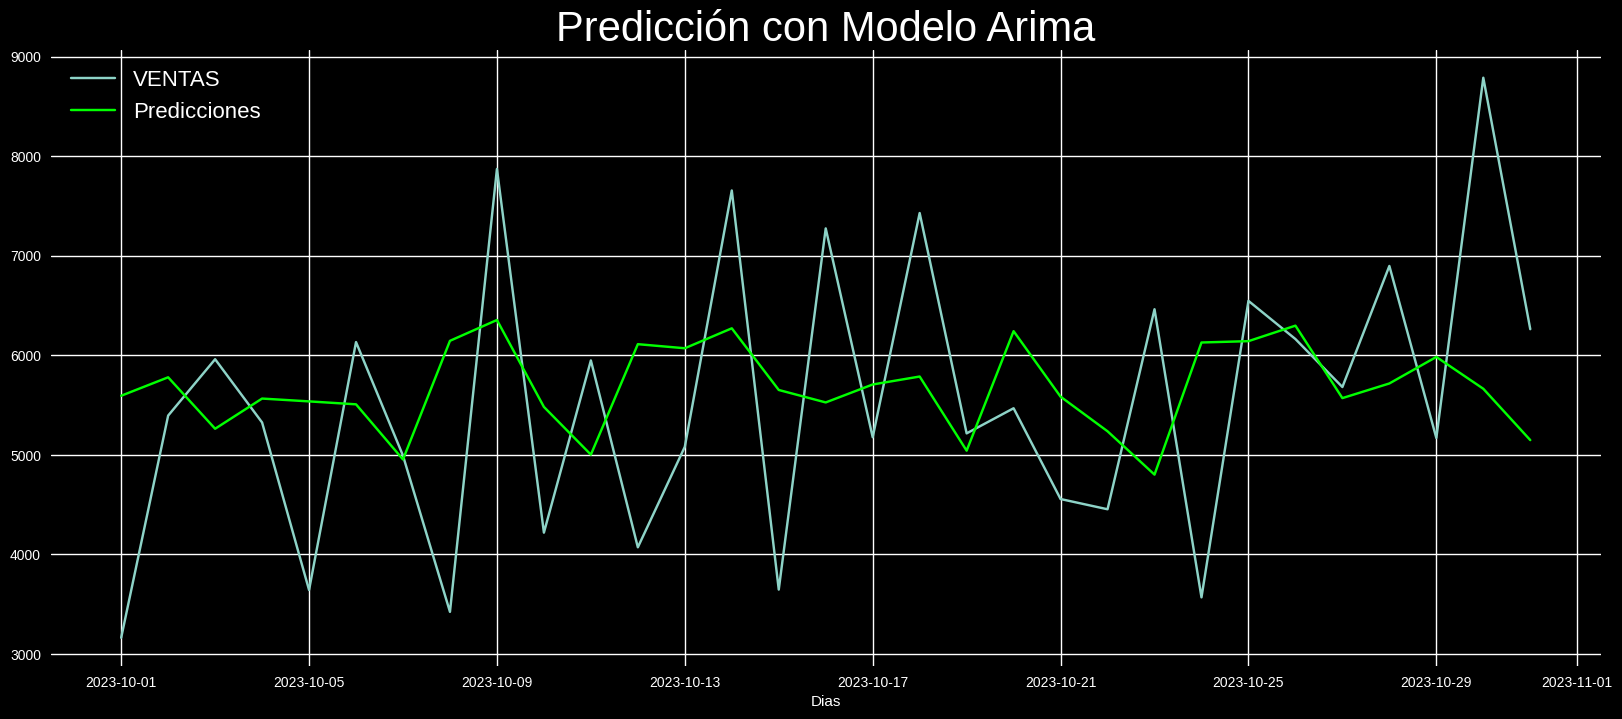

In [248]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (20, 8)

plt.plot(test["MontoBase"], label="VENTAS")
plt.plot(arima_pred, color="lime", label="Predicciones")
plt.title("Predicción con Modelo Arima", fontsize=30);
plt.xlabel('Dias')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show();

In [249]:
arima_pred2 = arima_result.predict(start = 1699,end=1728, typ="levels").rename("ARIMA Predictions")
arima_pred2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['ty

1699   5785.9811
1700   5041.4350
1701   6241.5798
1702   5583.6830
1703   5236.1489
1704   4800.8537
1705   6127.8505
1706   6141.3754
1707   6296.9939
1708   5569.3083
1709   5716.3574
1710   5982.8167
1711   5663.1628
1712   5147.4834
1713   6117.3705
1714   5729.8140
1715   5032.9106
1716   4970.6192
1717   6013.6499
1718   6009.0290
1719   6189.3431
1720   5555.8562
1721   5635.7944
1722   5796.0481
1723   5703.0813
1724   5089.1577
1725   6203.1693
1726   5857.9504
1727   5253.2336
1728   4943.2427
Name: ARIMA Predictions, dtype: float64

In [251]:
print(df_noviembre_sumaT.head())
#df_noviembre_sumaT.set_index('FechaMovimiento', inplace=True)
print(df_noviembre_sumaT.head())

                 MontoBase  Ventas_PROPHET  Ventas_LSTM  Ventas_ARIMA
FechaMovimiento                                                      
2023-11-01       5696.0218       5739.6116    4926.2163     5831.7232
2023-11-02       5620.0323       5214.8545    4911.6436     5088.5552
2023-11-03       5383.0235       6009.2257    4979.9668     6268.3993
2023-11-04       5875.4627       6837.9289    4998.0054     5587.8165
2023-11-05       2456.8761       4592.4800    4828.6982     5230.5764
                 MontoBase  Ventas_PROPHET  Ventas_LSTM  Ventas_ARIMA
FechaMovimiento                                                      
2023-11-01       5696.0218       5739.6116    4926.2163     5831.7232
2023-11-02       5620.0323       5214.8545    4911.6436     5088.5552
2023-11-03       5383.0235       6009.2257    4979.9668     6268.3993
2023-11-04       5875.4627       6837.9289    4998.0054     5587.8165
2023-11-05       2456.8761       4592.4800    4828.6982     5230.5764


In [252]:
arima_pred2.index = df_noviembre_sumaT.index

# Ahora puedes ver las predicciones con el índice correcto
print(arima_pred2)

FechaMovimiento
2023-11-01   5785.9811
2023-11-02   5041.4350
2023-11-03   6241.5798
2023-11-04   5583.6830
2023-11-05   5236.1489
2023-11-06   4800.8537
2023-11-07   6127.8505
2023-11-08   6141.3754
2023-11-09   6296.9939
2023-11-10   5569.3083
2023-11-11   5716.3574
2023-11-12   5982.8167
2023-11-13   5663.1628
2023-11-14   5147.4834
2023-11-15   6117.3705
2023-11-16   5729.8140
2023-11-17   5032.9106
2023-11-18   4970.6192
2023-11-19   6013.6499
2023-11-20   6009.0290
2023-11-21   6189.3431
2023-11-22   5555.8562
2023-11-23   5635.7944
2023-11-24   5796.0481
2023-11-25   5703.0813
2023-11-26   5089.1577
2023-11-27   6203.1693
2023-11-28   5857.9504
2023-11-29   5253.2336
2023-11-30   4943.2427
Name: ARIMA Predictions, dtype: float64


<ipython-input-253-2a97b7cdadf6>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


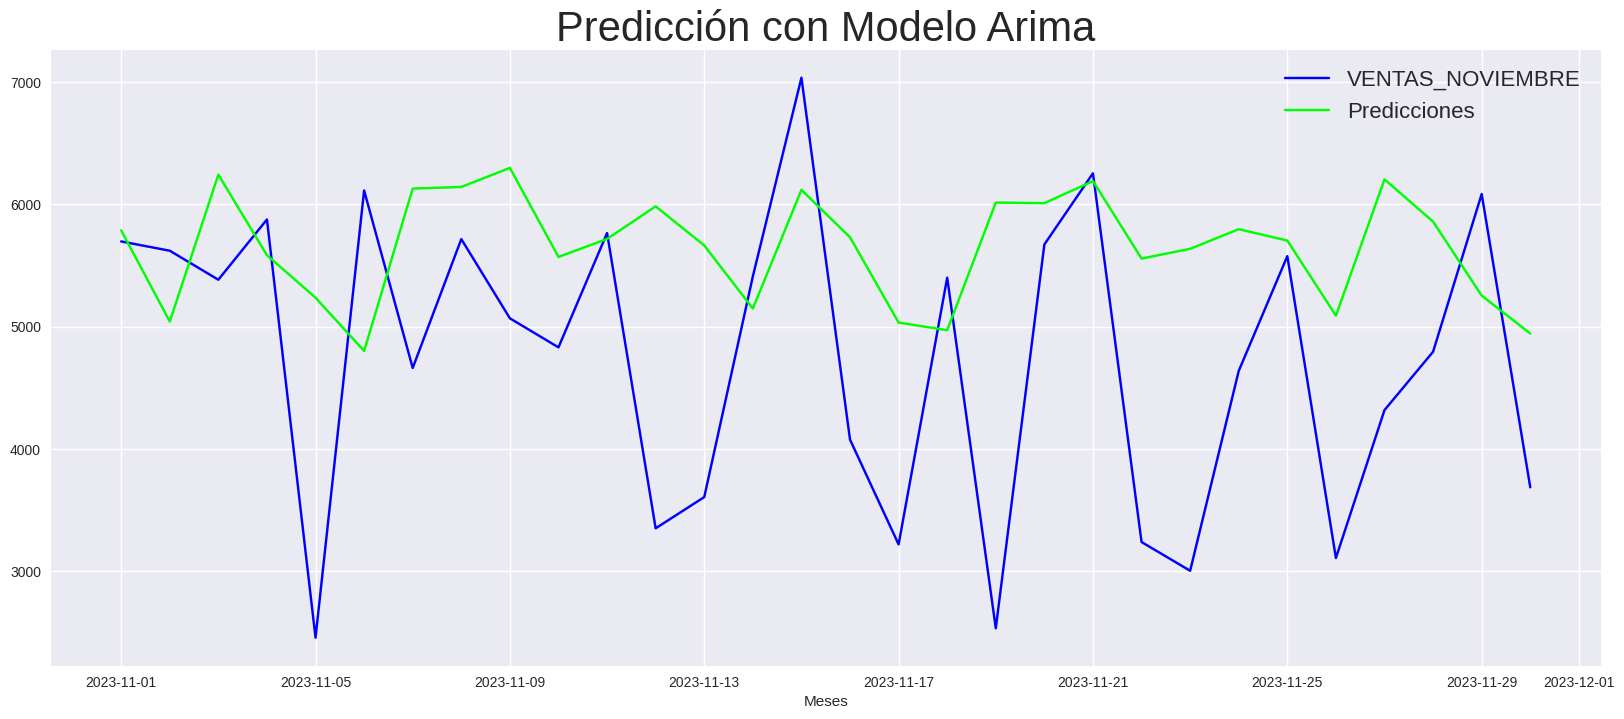

In [253]:
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (20, 8)

#plt.plot(test["MontoBase"],color="blue" ,label="VENTAS")
plt.plot(df_noviembre_sumaT["MontoBase"],color="BLUE" ,label="VENTAS_NOVIEMBRE")
plt.plot(arima_pred2, color="lime", label="Predicciones")
plt.title("Predicción con Modelo Arima", fontsize=30);
plt.xlabel('Meses')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show();

## Evaluar


In [254]:
# Suponiendo que df_noviembre_sumaT y predictions_future están en el mismo orden
df_noviembre_sumaT['Ventas_ARIMA'] = arima_pred2

# Imprimir el resultado
print(df_noviembre_sumaT.head(20))

                 MontoBase  Ventas_PROPHET  Ventas_LSTM  Ventas_ARIMA
FechaMovimiento                                                      
2023-11-01       5696.0218       5739.6116    4926.2163     5785.9811
2023-11-02       5620.0323       5214.8545    4911.6436     5041.4350
2023-11-03       5383.0235       6009.2257    4979.9668     6241.5798
2023-11-04       5875.4627       6837.9289    4998.0054     5583.6830
2023-11-05       2456.8761       4592.4800    4828.6982     5236.1489
2023-11-06       6112.4366       5729.4275    4963.7563     4800.8537
2023-11-07       4661.7902       5441.2526    4962.3066     6127.8505
2023-11-08       5715.1548       5619.6437    4781.1055     6141.3754
2023-11-09       5067.5888       5071.3258    5130.3101     6296.9939
2023-11-10       4830.1212       5842.0902    5041.3545     5569.3083
2023-11-11       5764.7558       6647.6892    5168.3281     5716.3574
2023-11-12       3351.1659       4380.2129    5053.6553     5982.8167
2023-11-13       360

In [255]:
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_ARIMA'])

Evaluation metric results:-
MSE is : 2334324.584781448
MAE is : 1223.8501844696923
R2 is : -0.5743832359618393 %
------------------------------
RMSE is : 1527.8496603990354
MAPE is : 33.76553239550418 %
------------------------------


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## SIN el 2020

In [256]:
df_arima_sin_2020 = df_todo_hasta_nov_sin_2020_prophet.rename(columns={
    'ds': 'FechaMovimiento',
    'y': 'MontoBase'
    })


# Establecer la columna 'FechaMovimiento' como índice
df_arima_sin_2020.set_index('FechaMovimiento', inplace=True)
# # Dejar la columna 'FechaMovimiento' como tipo fecha
#df_arima['FechaMovimiento'] = pd.to_datetime(df_arima['FechaMovimiento'])

print(df_arima_sin_2020.dtypes)
print(df_arima_sin_2020.head)

MontoBase    float64
dtype: object
<bound method NDFrame.head of                  MontoBase
FechaMovimiento           
2018-11-01       2670.9520
2018-11-02       4535.6180
2018-11-03       2401.9150
2018-11-04       2832.0090
2018-11-05       4109.9060
...                    ...
2023-10-27       5680.5769
2023-10-28       6896.5590
2023-10-29       5169.1250
2023-10-30       8787.0464
2023-10-31       6261.5983

[1415 rows x 1 columns]>


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


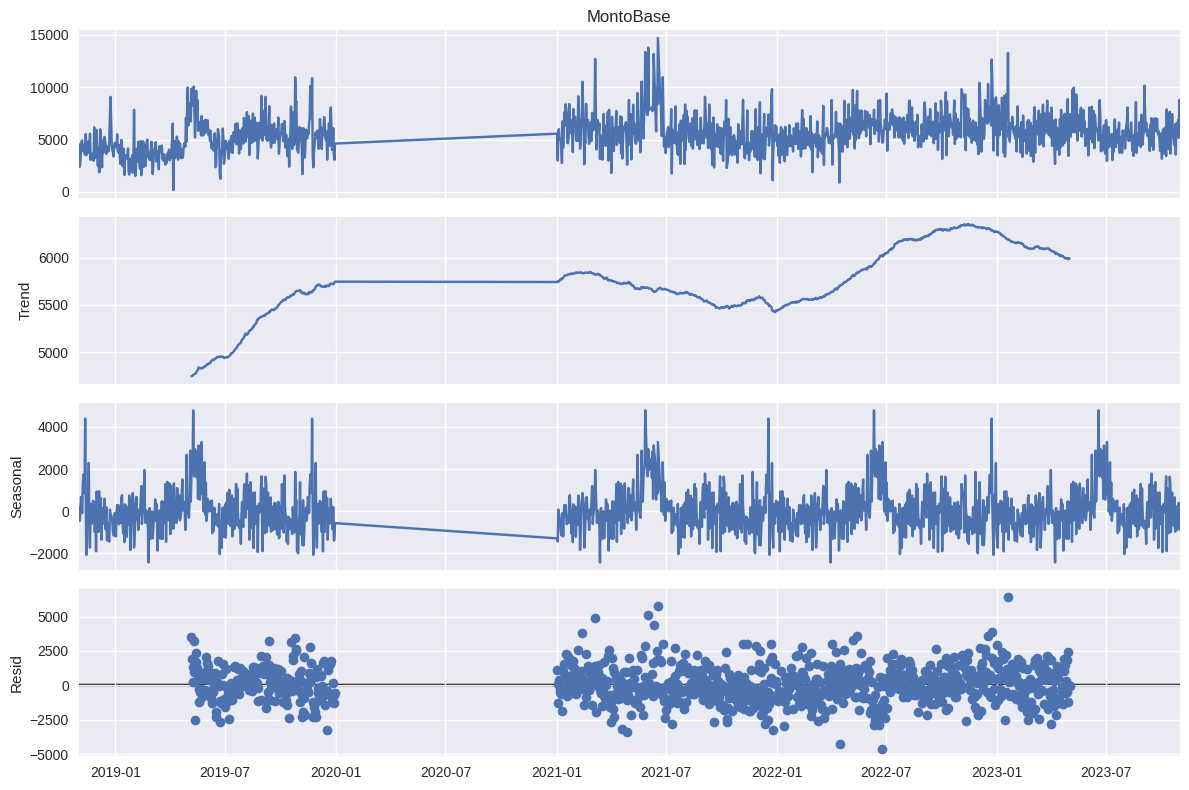

In [257]:
plt.rcParams["figure.figsize"] = (12, 8)
a = seasonal_decompose(df_arima_sin_2020["MontoBase"], model = "add", period=365)
a.plot();

In [258]:
# dividir en orden cronologico, entrenando sin el mes de octubre
train_size_s20 = int(len(df_arima_sin_2020) - 31)
train_s20, test_s20 = df_arima_sin_2020[0:train_size_s20], df_arima_sin_2020[train_size_s20:]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [259]:
train_s20.shape, test_s20.shape

((1384, 1), (31, 1))

In [260]:
print(train_s20)

                 MontoBase
FechaMovimiento           
2018-11-01       2670.9520
2018-11-02       4535.6180
2018-11-03       2401.9150
2018-11-04       2832.0090
2018-11-05       4109.9060
...                    ...
2023-09-26       5767.9455
2023-09-27       4841.5821
2023-09-28       3904.1615
2023-09-29       5049.1239
2023-09-30       5567.5508

[1384 rows x 1 columns]


In [261]:
arima_model_s20 = SARIMAX(train_s20["MontoBase"], order = (3,1,1), seasonal_order = (2,1,0,12))
arima_result_s20 = arima_model_s20.fit()
arima_result_s20.summary()



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Ch

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           MontoBase   No. Observations:                 1384
Model:             SARIMAX(3, 1, 1)x(2, 1, [], 12)   Log Likelihood              -12212.619
Date:                             Thu, 22 Feb 2024   AIC                          24439.238
Time:                                     18:24:16   BIC                          24475.801
Sample:                                          0   HQIC                         24452.921
                                            - 1384                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0848      0.025      3.367      0.001       0.035       0.134
ar.L2          0.1547      0.027      5.766      0.000       0.102       0.207
ar.L3          0.1578      0.024      6.531      0.000       0.110       0.205
ma.L1         -0.9997      0.024    -41.236      0.000      -1.047      -0.952
ar.S.L12      -0.6531      0.026    -25.086      0.000      -0.704      -0.602
ar.S.L24      -0.2391      0.026     -9.098      0.000      -0.291      -0.188
sigma2      3.166e+06   1.24e+05     25.533      0.000    2.92e+06    3.41e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):               101.17
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                             0.42
Prob(H) (two-sided):                  0.63   Kurtosis:                         4.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [262]:

arima_pred_s20 = arima_result_s20.predict(start = 1381,end=1410, typ="levels").rename("ARIMA Predictions sin 2020")
arima_pred_s20


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['ty

1381   5608.9933
1382   4738.2738
1383   5221.5808
1384   5878.4804
1385   6071.1657
1386   5401.2597
1387   5684.9408
1388   5644.6190
1389   5667.6029
1390   5033.1306
1391   6278.2656
1392   6412.8166
1393   5610.0340
1394   5018.6094
1395   6192.2003
1396   6246.3445
1397   6436.7860
1398   5735.8120
1399   5613.1091
1400   5812.8827
1401   5853.8057
1402   5101.5953
1403   6283.5000
1404   5582.1653
1405   5238.8575
1406   4824.1142
1407   6143.3279
1408   6308.2112
1409   6463.7945
1410   5651.2076
Name: ARIMA Predictions sin 2020, dtype: float64

In [263]:
arima_pred_s20.index = df_noviembre_suma_sin_2020.index

# Ahora puedes ver las predicciones con el índice correcto
print(arima_pred_s20)

0    5608.9933
1    4738.2738
2    5221.5808
3    5878.4804
4    6071.1657
5    5401.2597
6    5684.9408
7    5644.6190
8    5667.6029
9    5033.1306
10   6278.2656
11   6412.8166
12   5610.0340
13   5018.6094
14   6192.2003
15   6246.3445
16   6436.7860
17   5735.8120
18   5613.1091
19   5812.8827
20   5853.8057
21   5101.5953
22   6283.5000
23   5582.1653
24   5238.8575
25   4824.1142
26   6143.3279
27   6308.2112
28   6463.7945
29   5651.2076
Name: ARIMA Predictions sin 2020, dtype: float64


<ipython-input-264-05e78584d9d1>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


  FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM  Ventas_ARIMA
0      2023-11-01  5696.0218       5666.1033    5101.8203     5608.9933
1      2023-11-02  5620.0323       5037.3256    5004.7588     4738.2738
2      2023-11-03  5383.0235       6006.3166    4995.3428     5221.5808
3      2023-11-04  5875.4627       6795.9848    5016.0771     5878.4804
4      2023-11-05  2456.8761       4462.5432    4949.4077     6071.1657
  FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM  Ventas_ARIMA
0      2023-11-01  5696.0218       5666.1033    5101.8203     5608.9933
1      2023-11-02  5620.0323       5037.3256    5004.7588     4738.2738
2      2023-11-03  5383.0235       6006.3166    4995.3428     5221.5808
3      2023-11-04  5875.4627       6795.9848    5016.0771     5878.4804
4      2023-11-05  2456.8761       4462.5432    4949.4077     6071.1657


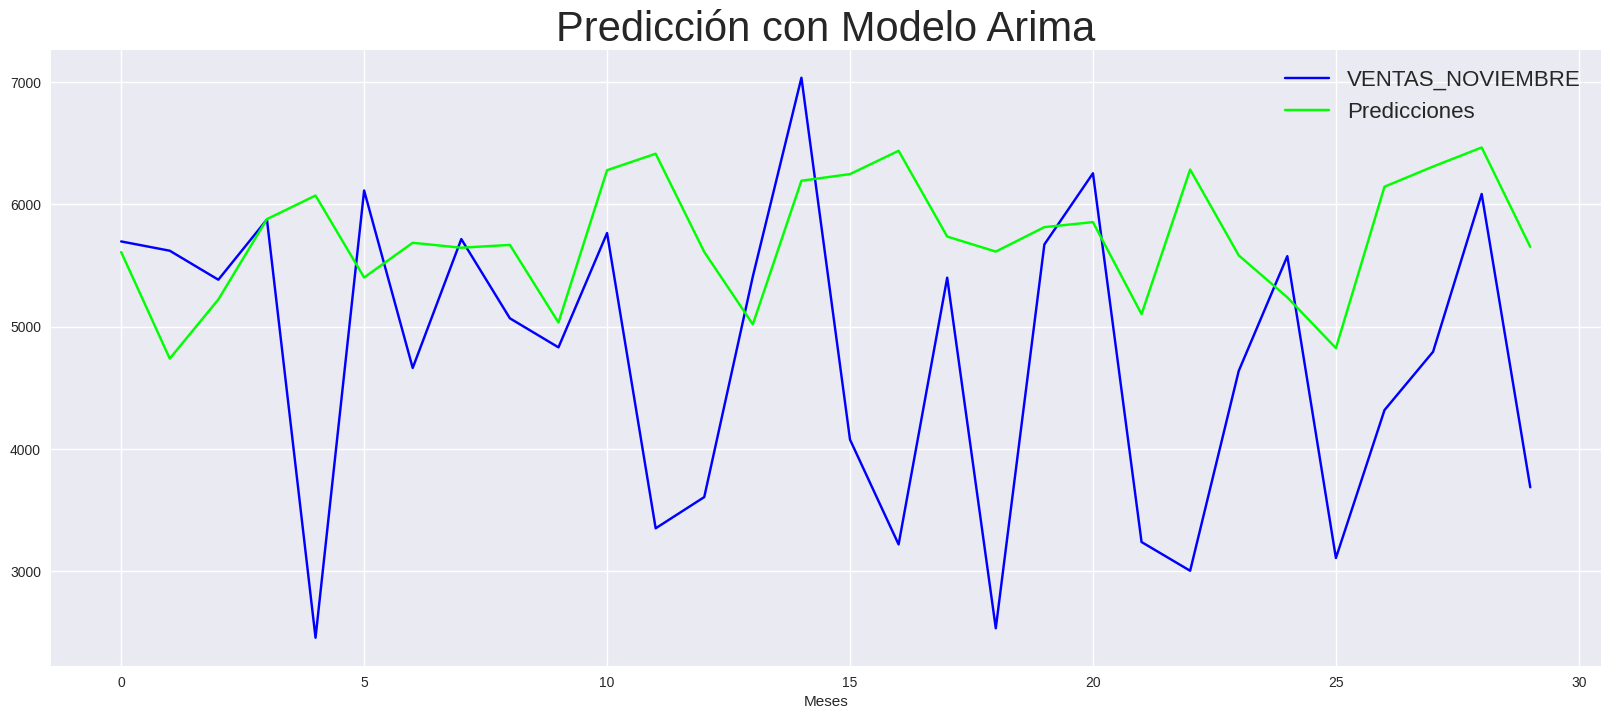

In [264]:
print(df_noviembre_suma_sin_2020.head())
#df_noviembre_suma_sin_2020.set_index('FechaMovimiento', inplace=True)
print(df_noviembre_suma_sin_2020.head())

plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (20, 8)
#plt.plot(test_s20["MontoBase"],color="blue" ,label="VENTAS")
plt.plot(df_noviembre_suma_sin_2020["MontoBase"],color="BLUE" ,label="VENTAS_NOVIEMBRE")
plt.plot(arima_pred_s20, color="lime", label="Predicciones")
plt.title("Predicción con Modelo Arima", fontsize=30);
plt.xlabel('Meses')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show();

## Evaluar

In [265]:
# PARA ELIMINAR LA COLUMNA CON VALORES 'NaN'
# print(df_noviembre_suma_sin_2020)
# df_noviembre_suma_sin_2020.drop(columns=['Ventas_ARIMA'], inplace=True)
print(df_noviembre_suma_sin_2020)

   FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM  Ventas_ARIMA
0       2023-11-01  5696.0218       5666.1033    5101.8203     5608.9933
1       2023-11-02  5620.0323       5037.3256    5004.7588     4738.2738
2       2023-11-03  5383.0235       6006.3166    4995.3428     5221.5808
3       2023-11-04  5875.4627       6795.9848    5016.0771     5878.4804
4       2023-11-05  2456.8761       4462.5432    4949.4077     6071.1657
5       2023-11-06  6112.4366       5694.2884    5007.0029     5401.2597
6       2023-11-07  4661.7902       5432.9613    5032.2441     5684.9408
7       2023-11-08  5715.1548       5651.3543    4953.4829     5644.6190
8       2023-11-09  5067.5888       4989.7885    5114.7881     5667.6029
9       2023-11-10  4830.1212       5924.7801    5131.3853     5033.1306
10      2023-11-11  5764.7558       6679.9813    5223.4297     6278.2656
11      2023-11-12  3351.1659       4312.3953    5192.4985     6412.8166
12      2023-11-13  3606.4129       5511.1368    51

In [266]:
# Suponiendo que df_noviembre_sumaT y predictions_future están en el mismo orden
df_noviembre_suma_sin_2020['Ventas_ARIMA'] = arima_pred_s20

# Imprimir el resultado
print(df_noviembre_suma_sin_2020.head(20))

   FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM  Ventas_ARIMA
0       2023-11-01  5696.0218       5666.1033    5101.8203     5608.9933
1       2023-11-02  5620.0323       5037.3256    5004.7588     4738.2738
2       2023-11-03  5383.0235       6006.3166    4995.3428     5221.5808
3       2023-11-04  5875.4627       6795.9848    5016.0771     5878.4804
4       2023-11-05  2456.8761       4462.5432    4949.4077     6071.1657
5       2023-11-06  6112.4366       5694.2884    5007.0029     5401.2597
6       2023-11-07  4661.7902       5432.9613    5032.2441     5684.9408
7       2023-11-08  5715.1548       5651.3543    4953.4829     5644.6190
8       2023-11-09  5067.5888       4989.7885    5114.7881     5667.6029
9       2023-11-10  4830.1212       5924.7801    5131.3853     5033.1306
10      2023-11-11  5764.7558       6679.9813    5223.4297     6278.2656
11      2023-11-12  3351.1659       4312.3953    5192.4985     6412.8166
12      2023-11-13  3606.4129       5511.1368    51

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [267]:
evaluacion_metrica(df_noviembre_suma_sin_2020['MontoBase'],df_noviembre_suma_sin_2020['Ventas_ARIMA'])

Evaluation metric results:-
MSE is : 2766100.1342928964
MAE is : 1244.4837533989567
R2 is : -0.8655938890478925 %
------------------------------
RMSE is : 1663.1596839428546
MAPE is : 35.49079264203398 %
------------------------------


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## TODAS LAS EVALUACIONES

In [268]:
print("--"*10,"EVALUACIÓN CON 2020","--"*10)
print("--"*5,"PROPHET","--"*5)
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_PROPHET'])
print("--"*5,"LSTM","--"*5)
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_LSTM'])
print("--"*5,"ARIMA","--"*5)
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_ARIMA'])
print("--"*10,"EVALUACIÓN SIN 2020","--"*10)
print("--"*5,"PROPHET","--"*5)
evaluacion_metrica(df_noviembre_suma_sin_2020['MontoBase'],df_noviembre_suma_sin_2020['Ventas_PROPHET'])
print("--"*5,"LSTM","--"*5)
evaluacion_metrica(df_noviembre_suma_sin_2020['MontoBase'],df_noviembre_suma_sin_2020['Ventas_LSTM'])
print("--"*5,"ARIMA","--"*5)
evaluacion_metrica(df_noviembre_suma_sin_2020['MontoBase'],df_noviembre_suma_sin_2020['Ventas_ARIMA'])

-------------------- EVALUACIÓN CON 2020 --------------------
---------- PROPHET ----------
Evaluation metric results:-
MSE is : 1242383.2159357269
MAE is : 926.7171844244527
R2 is : 0.16207569394523758 %
------------------------------
RMSE is : 1114.6224544372533
MAPE is : 23.85447363339454 %
------------------------------
---------- LSTM ----------
Evaluation metric results:-
MSE is : 1946269.77425365
MAE is : 1112.5641776302082
R2 is : -0.3126599981943232 %
------------------------------
RMSE is : 1395.0877299487836
MAPE is : 30.24273735699703 %
------------------------------
---------- ARIMA ----------
Evaluation metric results:-
MSE is : 2334324.584781448
MAE is : 1223.8501844696923
R2 is : -0.5743832359618393 %
------------------------------
RMSE is : 1527.8496603990354
MAPE is : 33.76553239550418 %
------------------------------
-------------------- EVALUACIÓN SIN 2020 --------------------
---------- PROPHET ----------
Evaluation metric results:-
MSE is : 1200197.5509256136
MAE 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


###Graficas de todas las Predicciones

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-269-0fc22ac8dbf5>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


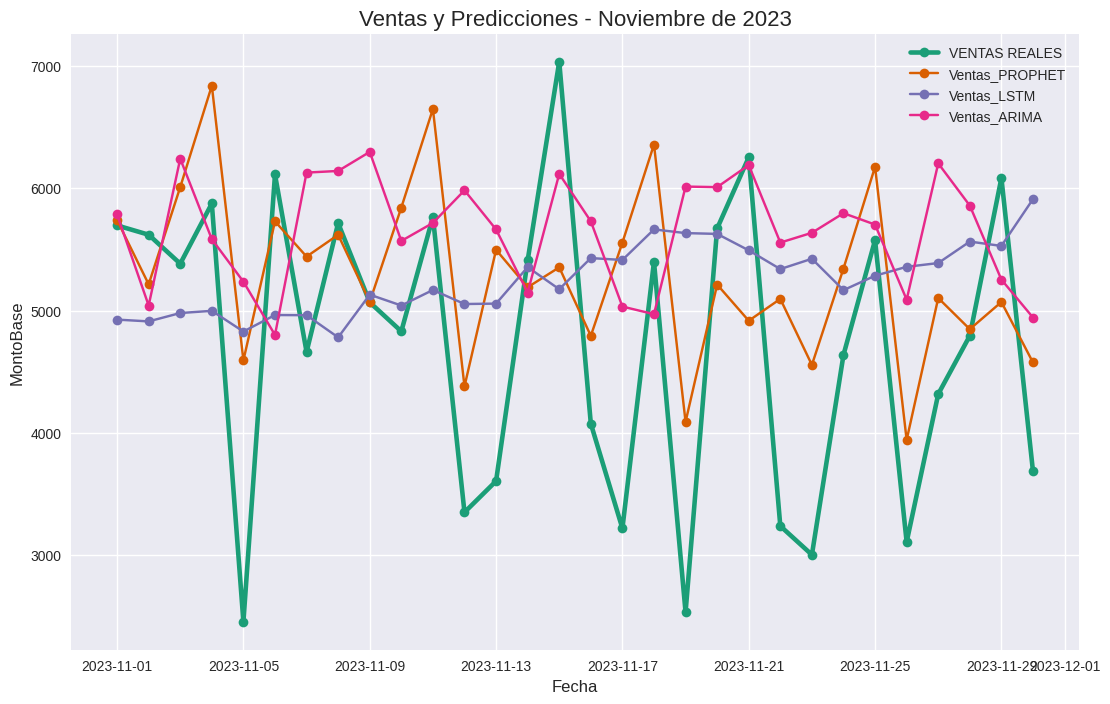

In [269]:
# Establecer el estilo de Seaborn
plt.style.use('seaborn')
sns.set_palette("Dark2")

# Graficar los datos para df_noviembre_sumaT
plt.figure(figsize=(13, 8))
plt.plot(df_noviembre_sumaT.index, df_noviembre_sumaT['MontoBase'], label='VENTAS REALES', marker='o', linewidth=3.3)
plt.plot(df_noviembre_sumaT.index, df_noviembre_sumaT['Ventas_PROPHET'], label='Ventas_PROPHET', marker='o')
plt.plot(df_noviembre_sumaT.index, df_noviembre_sumaT['Ventas_LSTM'], label='Ventas_LSTM', marker='o')
plt.plot(df_noviembre_sumaT.index, df_noviembre_sumaT['Ventas_ARIMA'], label='Ventas_ARIMA', marker='o')
plt.title('Ventas y Predicciones - Noviembre de 2023', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('MontoBase', fontsize=12)
plt.legend()
plt.savefig('ventas_predicciones_sumaT.png')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-270-85d2d79c9e93>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


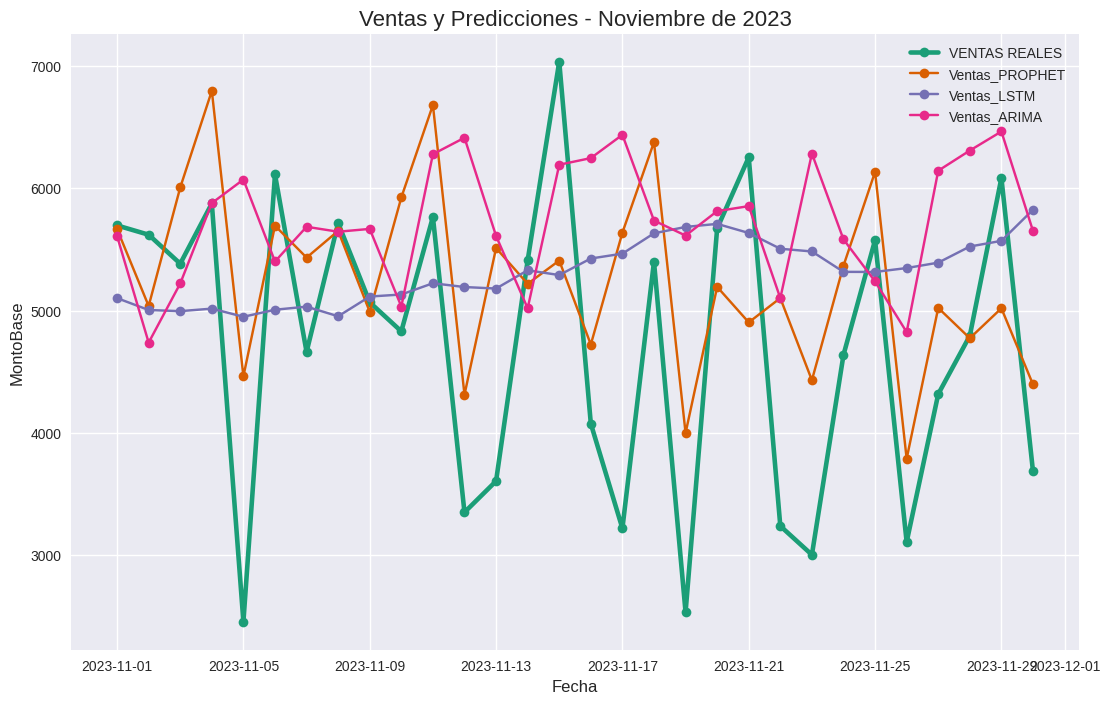

In [270]:
# Establecer el estilo de Seaborn
plt.style.use('seaborn')
sns.set_palette("Dark2")

# Graficar los datos para df_noviembre_suma_sin_2020
plt.figure(figsize=(13, 8))
plt.plot(df_noviembre_suma_sin_2020['FechaMovimiento'], df_noviembre_suma_sin_2020['MontoBase'], label='VENTAS REALES', marker='o', linewidth=3.3)
plt.plot(df_noviembre_suma_sin_2020['FechaMovimiento'], df_noviembre_suma_sin_2020['Ventas_PROPHET'], label='Ventas_PROPHET', marker='o')
plt.plot(df_noviembre_suma_sin_2020['FechaMovimiento'], df_noviembre_suma_sin_2020['Ventas_LSTM'], label='Ventas_LSTM', marker='o')
plt.plot(df_noviembre_suma_sin_2020['FechaMovimiento'], df_noviembre_suma_sin_2020['Ventas_ARIMA'], label='Ventas_ARIMA', marker='o')
plt.title('Ventas y Predicciones - Noviembre de 2023', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('MontoBase', fontsize=12)
plt.legend()
plt.savefig('ventas_predicciones_sin_2020.png')
plt.show()